### UP2 PB1 batch correction, FlowSOM unsupervised clustering
### Modified at 07/28/2021
### Date: 3/14/2022
### Author: Ziyuan He
### User: Nick Moss
###############################################################################
### Unsupervised clustering ananlysis for flow data analysis for UP2 BR2 cohort - PB1
#### with Spectre package workflow

Advantage: Spectre use data.table as basic format for data storage and processing.

Addtional instruction can be found on https://immunedynamics.io/spectre/ and for data.table in R https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html

#### Steps:
1. input: load Total live cells FCS files exported for all 4 panels
2. access the batch effects in the batch controls samples
2. perform FlowSOM with shared backbone markers (CD45, CD3, CD14, CD19, CD56, HLA-DR) with low K 
3. apply normalization on all markers per clusters
3. output the batch corrected fcs files
4. access the effect of batch correction

In [4]:
# open R in terminal
#IRkernel::installspec(name = 'spectre', displayname = 'spectre')
BiocManager::install("CATALYST")
devtools::install_github("immunedynamics/spectre")
install.packages("uwot")
install.packages("janitor")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'CATALYST'”
Old packages: 'rgdal', 'sf'

Skipping install of 'Spectre' from a github remote, the SHA1 (620e7840) has not changed since last install.
  Use `force = TRUE` to force installation

Warning message in install.packages("uwot"):
“installation of package ‘uwot’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
###################################################### 
##load packages 
######################################################
library(Spectre)
library(glue)
library(lubridate)
Spectre::package.check() # Check that all required packages are installed
suppressPackageStartupMessages(Spectre::package.load()) 
suppressPackageStartupMessages(library('tidyverse'))
suppressPackageStartupMessages(library('dtplyr'))
suppressPackageStartupMessages(library('data.table'))
Sys.setenv(TZ='America/Los_Angeles')
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

Package: Spectre

 -- Version (on disk): 1.0.0

 -- Version (loaded):  1.0.0

 -- Install date:      2022-03-17

 -- Install source:    Github (immunedynamics/spectre@620e78409bdb6deadf5a534c1e184daf5051f04d)

 -- Install path:      /home/jupyter/libs/spectre/lib/R/library/Spectre

 -- R version:         R version 4.1.2 (2021-11-01)

 -- OS:                Ubuntu 20.04.3 LTS

               

Checking dependency packages...

 -- All packages successfully installed.

               

Check out 'https://immunedynamics.github.io/spectre/' for protocols



In [6]:
##########################################
## define working directories
##########################################
today <- lubridate::today(tzone = "PST")

# define project name
proj_name <- 'PM1_unsup'
panel_name <- 'PM1'

### define working path
output_path <- as.character(glue('/home/jupyter/FH3/flow/{panel_name}-unsupervised-clustering/output'))

# change the following directories to your local path
fig_path <- as.character(glue('/home/jupyter/FH3/flow/{panel_name}-unsupervised-clustering/output/figures'))
#meta_path <- as.character('/home/jupyter/{panel_name}/meta')
panel_path <- '/home/jupyter/FH3/flow/flow-unsupervised-clustering/panels'
fcs_path <- as.character(glue("/home/jupyter/FH3/flow/fcs/{panel_name}"))
# create the directory to save figures
if(!dir.exists(fig_path)){dir.create(fig_path)} 


In [7]:
# load the customized fucntions for flow ananlysis
source('/home/jupyter/git_repos/flow-unsupervised-clustering/R/AIFI_R_flow_spectre_functions_ZH.r')

In [8]:
length(list.files(fcs_path))

[1] 101

In [9]:
##########################################
## construct meta data from file names 
##########################################
# construct sample infomation table from file names
sample_info <- meta_construct(fcs_path)
# construct panel information from fcs
# panel <- panel_extract_fcs(meta_data_ps)

In [10]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")
# create a color palette for n=32 
coul <- brewer.pal(11, "Spectral") 
n_samples <- sample_info %>% nrow()
n_batches <- sample_info %>% distinct(batch)%>% nrow()
# create a color palette for number of samples
samples_pal <- colorRampPalette(npg_color)(n_samples)
batch_pal <- colorRampPalette(npg_color)(n_batches)

In [11]:
# load the panel info with manual breakdown
panel <- read_csv(file.path(panel_path, 
                            glue('AIFI_flow_{panel_name}_panel_breakdown.csv')), 
                     col_types = cols())

In [12]:
### Define backbone markers used for the first clustering   
bb_markers <- c('CD45', 'CD3', 'CD14', 'CD19', 'CD56', 'HLA-DR')
# define the fluorescent channels to do transformation
fluorchnls <- panel %>% dplyr::filter(chn_type == "fluorchnls" & antigen != 'Viability') %>%
  pull(antigen) %>% c()

# define the colnames of all the transformed markers
logc.cols <-  paste0(fluorchnls, "_logicle")
# define the backbone markers used for the first clustering
bb.logc.cols <- paste0(bb_markers, "_logicle")

# define the marker used for clustering
cluster.cols <- panel %>% dplyr::filter(used_for_clustering == 'Yes') %>% pull(antigen)
# define the align colnames
align.cols <- paste0(logc.cols, '_aligned')

### 2. Import and prep data

In [13]:
####################################
#### 2. Import and prep data
####################################
# load fcs data into data.table in Spectre
# if live fcs files as input
flow_unnorm_data <- spec_load_fcs(fcs_path, sample_info, panel)

# if the data is prepared through the script PS1_flow_live_cells_gates.ipynb 
# and stored in the big csv format, 
# run the following line instead.
#flow_unnorm_data <- fread(file.path(output_path, 'UP2_unsup_PB1_flow_viable_cells.csv'))


Removing '.csv' or '.fcs' extension

Step 1/3. Mapping data

Step 2/3. Merging data

Step 3/3. Returning data



In [14]:
# take a look of the data
colnames(flow_unnorm_data) <- c(pull(panel, antigen), "sample_id")

In [15]:
# check the colnames of the data.table constructed
flow_unnorm_data %>% colnames()
colnames(flow_unnorm_data) %in% pull(panel, antigen)
# they should be consitent with antigens names in the panel table

[1] "Time"           "SSC-W"          "SSC-H"          "SSC-A"         
 [5] "FSC-W"          "FSC-H"          "FSC-A"          "SSC-B-W"       
 [9] "SSC-B-H"        "SSC-B-A"        "CD14"           "CD45"          
[13] "CD15"           "CD56"           "CD304"          "CD33"          
[17] "CD11c"          "CX3CR1"         "HLA-DR"         "Viability"     
[21] "CD192 (CCR2)"   "CD3"            "CD11b"          "CD40"          
[25] "CD80"           "CD141"          "CD123"          "CD172a (SIRPa)"
[29] "CD19"           "CD370 (CLEC9A)" "CD86"           "CD16"          
[33] "CD197 (CCR7)"   "CD274 (PD-L1)"  "CD195 (CCR5)"   "CD1c"          
[37] "sample_id"

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[37] FALSE

In [16]:
### transform the flow data ### 
# arcsinh transformation for flow data
# mm_pm_tran <- do.asinh(mm_pm_data, fluorchnls, cofactor = 150)
# logicle transformation for flow data
flow_unnorm_data <- do.logicle(flow_unnorm_data, auto.infer.function=FALSE,
                           use.cols=fluorchnls, linearisation.width=1.15, 
               max.scale.val=1000000)

Formulating logicle transformation function

Transforming data

Converting data back to data.table



In [17]:
flow_unnorm_data %>% head()

Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,FSC-A,SSC-B-W,SSC-B-H,SSC-B-A,⋯,CD123_logicle,CD172a (SIRPa)_logicle,CD19_logicle,CD370 (CLEC9A)_logicle,CD86_logicle,CD16_logicle,CD197 (CCR7)_logicle,CD274 (PD-L1)_logicle,CD195 (CCR5)_logicle,CD1c_logicle
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48781,736962.8,278307,341836.5,714828.8,1366839,1628426.5,709524.7,350373,414330.5,⋯,1.245488,1.163444,1.1123706,1.214171,1.237007,1.268728,3.364111,1.228262,1.162233,1.160139
48787,770765.9,402751,517377.9,757974.3,1186677,1499117.8,737853.1,528054,649377.1,⋯,1.306300,1.087551,1.2746579,1.070511,1.347271,2.307392,1.163422,1.069472,1.201047,1.184281
48789,692739.9,392814,453529.9,698235.8,1229568,1430880.5,667871.2,469581,522699.4,⋯,1.273838,1.238608,0.7893503,1.172493,1.378494,1.201721,3.590779,1.158719,1.149553,1.031686
48792,732573.6,413606,504994.8,759627.6,1199470,1518584.1,728710.5,477529,579967.3,⋯,1.263113,1.236239,1.4009781,1.048789,1.306498,1.162944,3.060658,1.224641,1.274618,1.130065
48798,741790.5,218845,270561.9,707277.2,735904,867480.2,748267.8,245389,306027.8,⋯,1.325270,1.169213,1.2680568,1.594265,1.139552,1.237644,3.183376,1.420054,1.878785,3.074867
48800,758361.0,402004,508106.9,741996.4,1503697,1859562.8,731940.9,476070,580758.6,⋯,1.274860,1.182319,1.2002294,1.158270,1.162206,1.442001,1.254816,1.086723,1.310717,1.202222


In [18]:
# select the relevant metadata to add 
sample_info_fl <- sample_info %>% select(batch, sample_id, sample_type)
# add the metadata into the fcs data
flow_unnorm_data <- do.add.cols(flow_unnorm_data, "sample_id", sample_info_fl, "sample_id")
flow_unnorm_data[, sample_id:=as.character(sample_id)]

Step 1/3. Mapping data

Step 2/3. Merging data

Step 3/3. Returning data



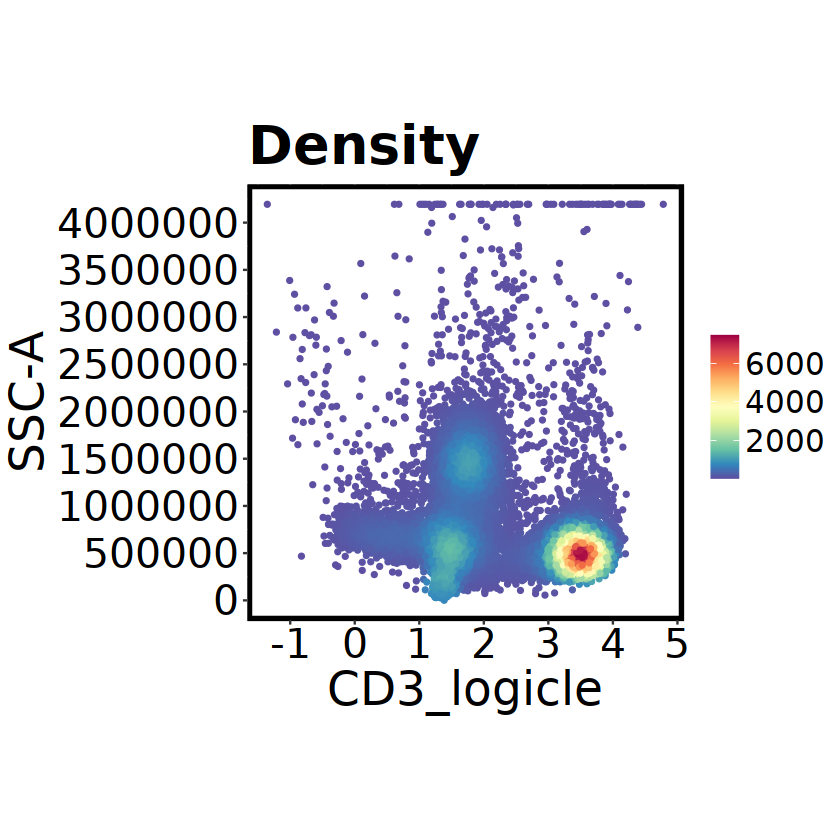

In [19]:
# plot the transformed data and check
plot.against <- 'SSC-A'
# for(i in transformed.cols){
#   make.colour.plot(do.subsample(mm_pm_tran, 20000), i, plot.against)
# }
make.colour.plot(do.subsample(flow_unnorm_data, 20000), 'CD3_logicle', plot.against,
                 save.to.disk=TRUE,
                path=file.path(fig_path))

## check batch effects in the batch controls
1. Flowsom clustering on bridge controls with backbone markers of k=6
2. Annotate the clusters based on the markers experssion into: Monocytes, T cells, B cells, NK cells, DCs, Other cells.
3. mapping the clinical samples into the SOM generated by the bridge controls

In [20]:
# only look at the batch controls first to check batch effects
flow_unnorm_bc <- flow_unnorm_data[sample_type == 'batch controller']

In [21]:
# check number of samples in total and batches
flow_unnorm_bc %>% distinct(sample_id) %>% as_tibble() %>% nrow()
flow_unnorm_data %>% distinct(sample_id) %>% as_tibble() %>% nrow()

[1] 9

[1] 101

In [22]:
# run flowsom in the batch controls and return the flowsom models
fm_unnorm_bc.md <- run_flowsom_model(flow_unnorm_bc, 
                                    use.cols=bb.logc.cols, 
                             #meta.clust.name="FlowSOM_meta10",
                             xdim=10,
                             ydim=10,
                             meta.k=12,
                             clust.seed=3)

Preparing data

Starting FlowSOM

Finished FlowSOM



In [23]:
# if wanted, save the flowsom model for future mapping
# fm_unnorm_bc.md %>% saveRDS(file.path(output_path, 
#                                       paste0(proj_name, panel_name, 
#                                              '_bc_fm12_bb_flowsom_model.rds')))
fm_unnorm_bc.md

FlowSOM model trained on 3873792 cells and 6 markers, 
 using a 10x10 grid (100 clusters) and 12 metaclusters.

Markers used:  column CD45_logicle from dataset <CD45_logicle>, column CD3_logicle from dataset <CD3_logicle>, column CD14_logicle from dataset <CD14_logicle>, column CD19_logicle from dataset <CD19_logicle>, column CD56_logicle from dataset <CD56_logicle>, column HLA-DR_logicle from dataset <HLA-DR_logicle>

Metacluster cell count:
   MC 1    MC 2    MC 3    MC 4    MC 5    MC 6    MC 7    MC 8    MC 9   MC 10 
   9000 1907587  567690  274014    3153   38169   15392  373537  673859    6672 
  MC 11   MC 12 
   2769    1950 

 60718 cells (1.57%) are further than 4 MAD from their cluster center.

In [24]:
# add the flowsom labels back to the orginal batch controls dataset
fm_unnorm_bc <- fm_cluster_match(flow_unnorm_bc, fm_unnorm_bc.md)
# change the names of colnames of the orginal flowsom clustring with backbone clusters
setnames(fm_unnorm_bc, c('FlowSOM_cluster', 'FlowSOM_metacluster'),
          c('FlowSOM_cluster_bb', 'FlowSOM_meta_bb'))
# the meta cluster identity is saved in FlowSOM_meta_bb column

In [25]:
fm_unnorm_bc %>% head()

Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,FSC-A,SSC-B-W,SSC-B-H,SSC-B-A,⋯,CD86_logicle,CD16_logicle,CD197 (CCR7)_logicle,CD274 (PD-L1)_logicle,CD195 (CCR5)_logicle,CD1c_logicle,batch,sample_type,FlowSOM_cluster_bb,FlowSOM_meta_bb
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
48649,786962.7,1356785,1779565.2,798060.3,1186704,1578435.6,784971.4,1293606,1692406.1,⋯,2.556249,1.319385,1.3075557,1.046133,1.0608384,0.9524544,B011,batch controller,85,9
48653,794625.9,534054,707288.6,736194.6,1246033,1528871.2,768187.7,594243,760816.9,⋯,1.058212,3.881971,0.5902025,1.523297,0.9331526,0.9241153,B011,batch controller,8,3
48656,750109.9,342927,428721.6,692187.2,729001,841008.6,732361.6,415840,507575.5,⋯,1.252312,1.086481,3.0281559,1.879081,1.8941145,2.6772043,B011,batch controller,16,2
48659,712202.4,344652,409103.3,704495.9,1357614,1594055.9,681929.8,506798,576001.1,⋯,1.286505,1.242748,1.4985607,1.382343,1.3543600,1.2019387,B011,batch controller,31,2
48664,707542.1,285113,336215.8,701658.2,1123203,1313507.8,689885.6,325643,374427.3,⋯,1.395292,1.206265,2.9377293,1.180083,1.2721369,1.5110809,B011,batch controller,89,8
48664,770025.5,757359,971976.2,725767.4,1461910,1768344.4,761848.6,790011,1003114.6,⋯,1.214179,3.976060,0.6001166,1.581078,1.0322787,1.0913328,B011,batch controller,9,3


In [26]:
# calcualte MFI and plot heatmap per cluster based on backbone clusters
flow_unnorm_bc.mfi <- do.aggregate(dat = fm_unnorm_bc, use.cols = bb.logc.cols, by = 'FlowSOM_meta_bb')
# make a heatmap
make.pheatmap(dat = flow_unnorm_bc.mfi, sample.col = 'FlowSOM_meta_bb', plot.cols = bb.logc.cols, 
                path=file.path(fig_path),
              normalise=TRUE,
              plot.title='fm6_backbone',
              standard.colours='BuPu',
              file.name=paste0(proj_name, panel_name,
                               '_bc_bb_markers_flowsom12_bb_seed3_123_exprs_heatmap.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/FH3/flow/PM1-unsupervised-clustering/output/figuresPM1_unsupPM1_bc_bb_markers_flowsom12_bb_seed3_123_exprs_heatmap.pdf



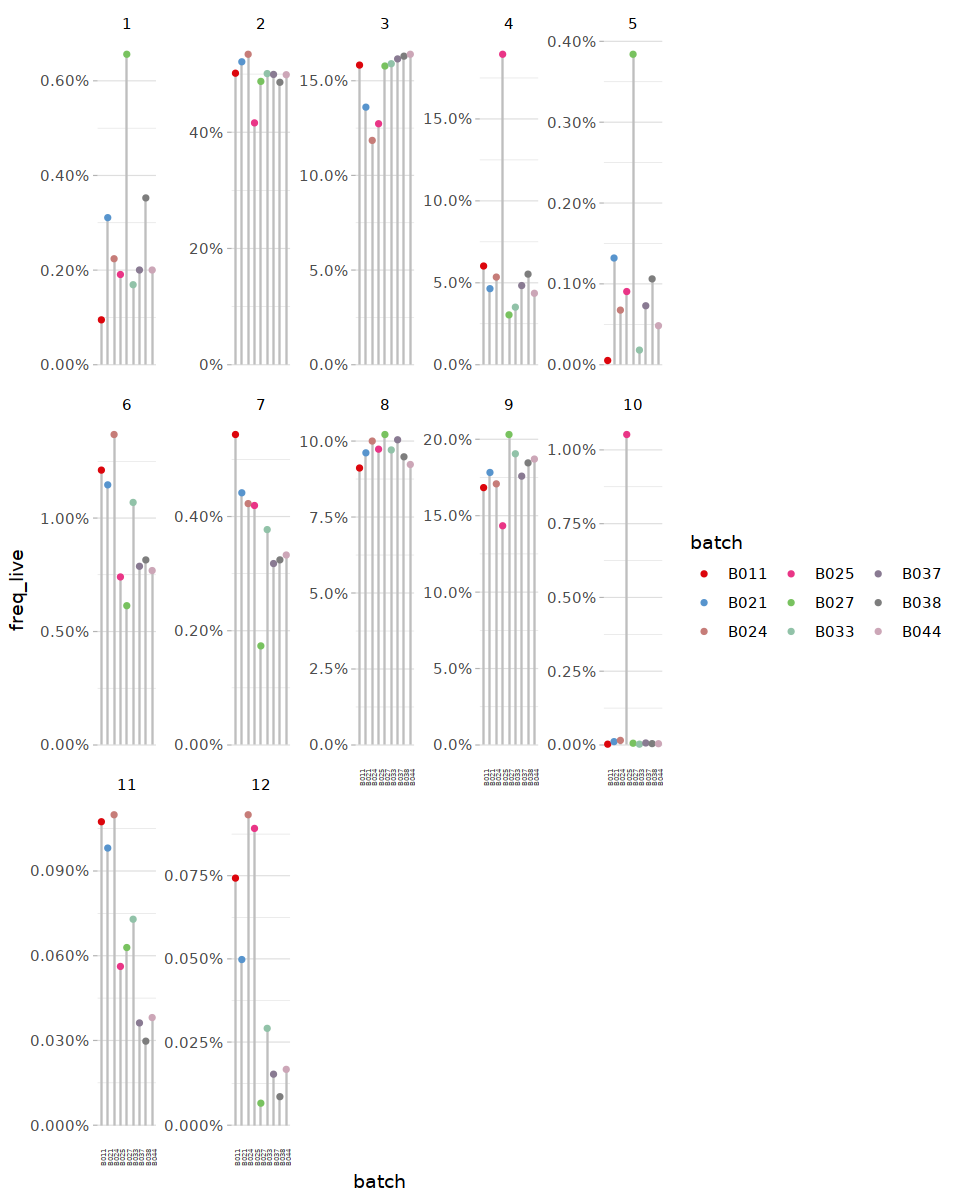

In [27]:
batch_pal <- colorRampPalette(npg_color)(length(unique(fm_unnorm_bc$batch)))

fig.size(10,8)
# plot the frequency of clusters in batch controls
Spec_plot_cluter_freq(fm_unnorm_bc, cluster.cols='FlowSOM_meta_bb', 
                      group.cols='batch', figname=paste0(proj_name, panel_name,
                               '_PS1_unnomalized_bc_bb_fm12_'))

In [28]:
fm_unnorm_bc %>% colnames()

[1] "Time"                   "SSC-W"                  "SSC-H"                 
 [4] "SSC-A"                  "FSC-W"                  "FSC-H"                 
 [7] "FSC-A"                  "SSC-B-W"                "SSC-B-H"               
[10] "SSC-B-A"                "CD14"                   "CD45"                  
[13] "CD15"                   "CD56"                   "CD304"                 
[16] "CD33"                   "CD11c"                  "CX3CR1"                
[19] "HLA-DR"                 "Viability"              "CD192 (CCR2)"          
[22] "CD3"                    "CD11b"                  "CD40"                  
[25] "CD80"                   "CD141"                  "CD123"                 
[28] "CD172a (SIRPa)"         "CD19"                   "CD370 (CLEC9A)"        
[31] "CD86"                   "CD16"                   "CD197 (CCR7)"          
[34] "CD274 (PD-L1)"          "CD195 (CCR5)"           "CD1c"                  
[37] "sample_id"              "CD14_logicle"           "CD45_logicle"          
[40] "CD15_logicle"           "CD56_logicle"           "CD304_logicle"         
[43] "CD33_logicle"           "CD11c_logicle"          "CX3CR1_logicle"        
[46] "HLA-DR_logicle"         "CD192 (CCR2)_logicle"   "CD3_logicle"           
[49] "CD11b_logicle"          "CD40_logicle"           "CD80_logicle"          
[52] "CD141_logicle"          "CD123_logicle"          "CD172a (SIRPa)_logicle"
[55] "CD19_logicle"           "CD370 (CLEC9A)_logicle" "CD86_logicle"          
[58] "CD16_logicle"           "CD197 (CCR7)_logicle"   "CD274 (PD-L1)_logicle" 
[61] "CD195 (CCR5)_logicle"   "CD1c_logicle"           "batch"                 
[64] "sample_type"            "FlowSOM_cluster_bb"     "FlowSOM_meta_bb"

Warning message:
“Removed 9 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 434 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 20 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 21 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 9 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 575 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 14 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 29 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 9 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 390 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 14 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 28 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 9 

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]



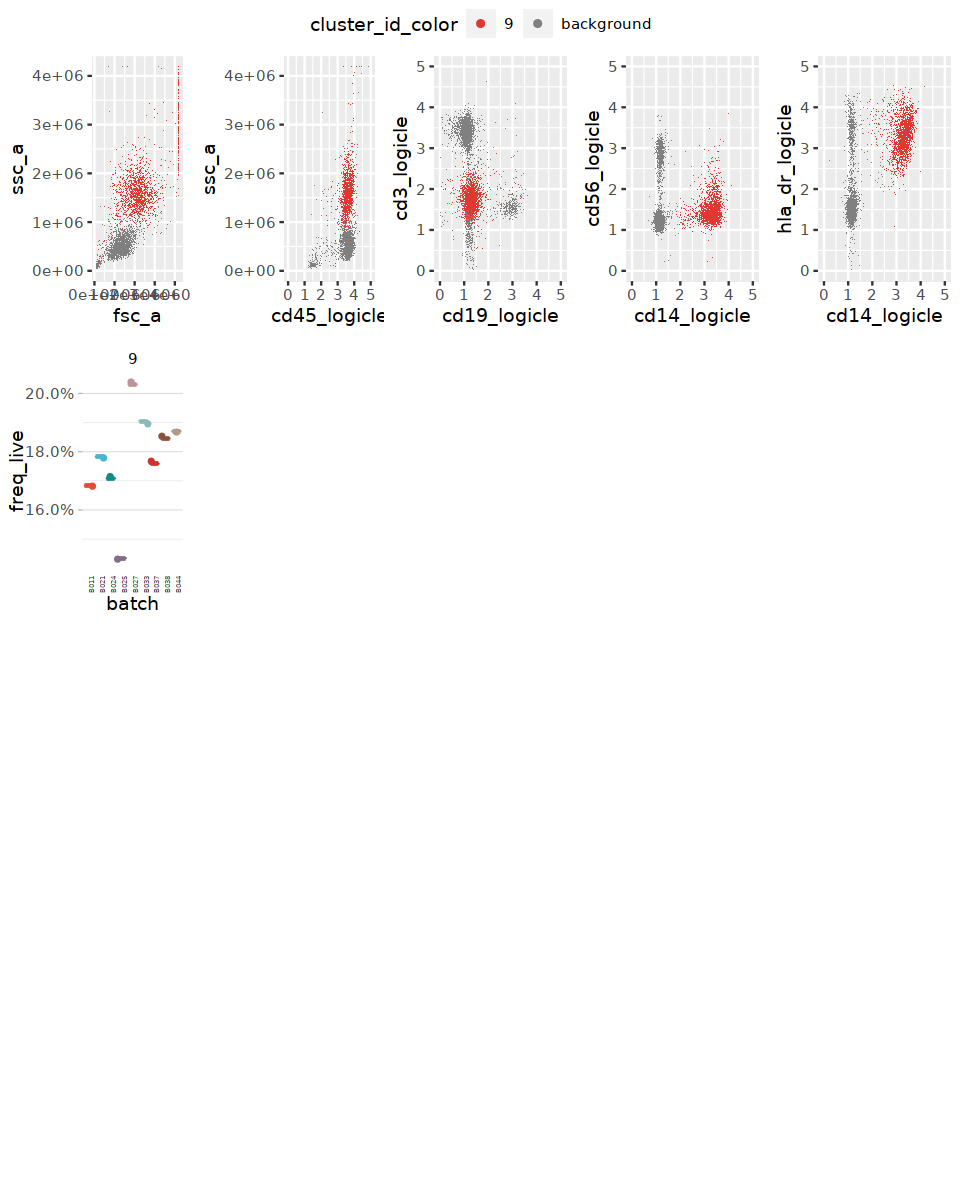

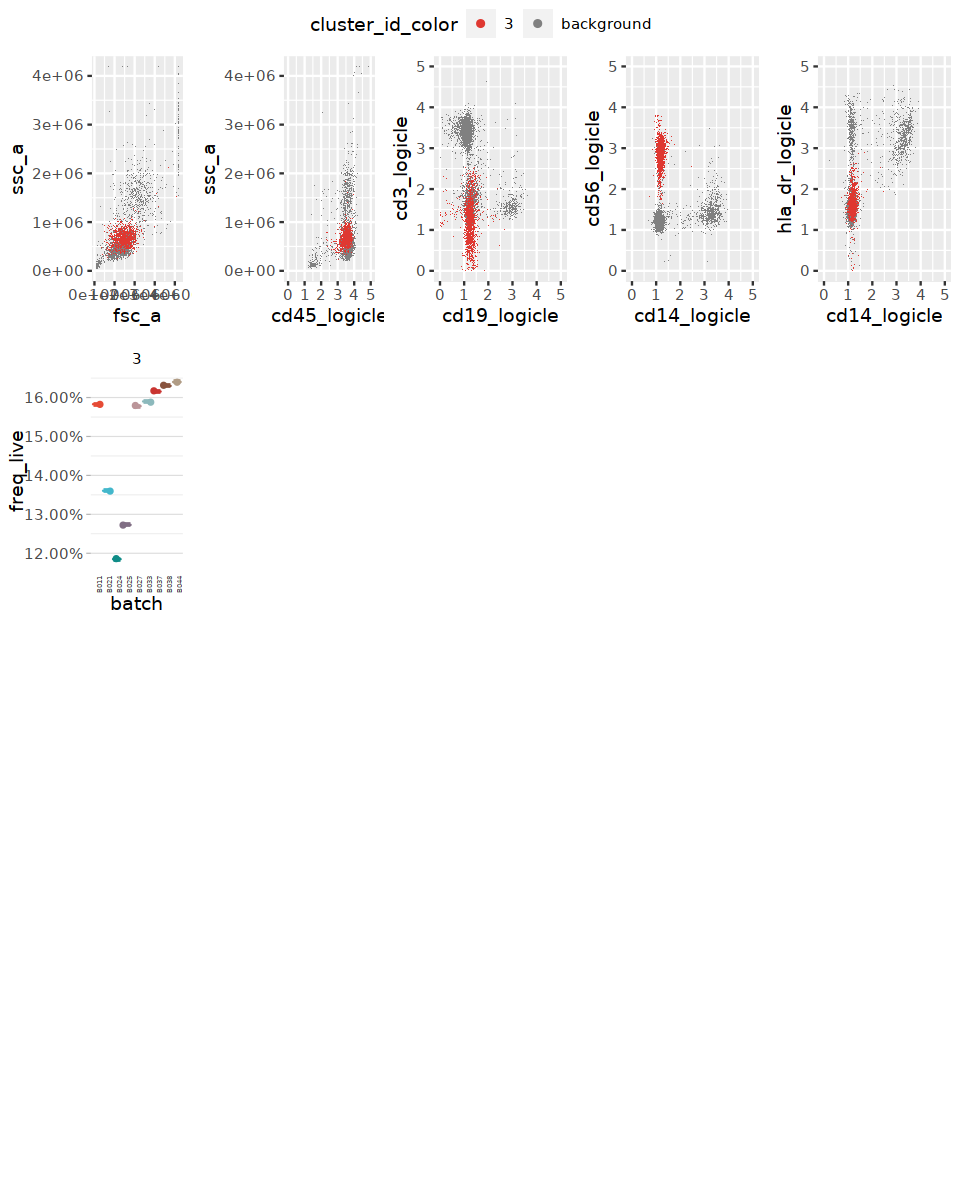

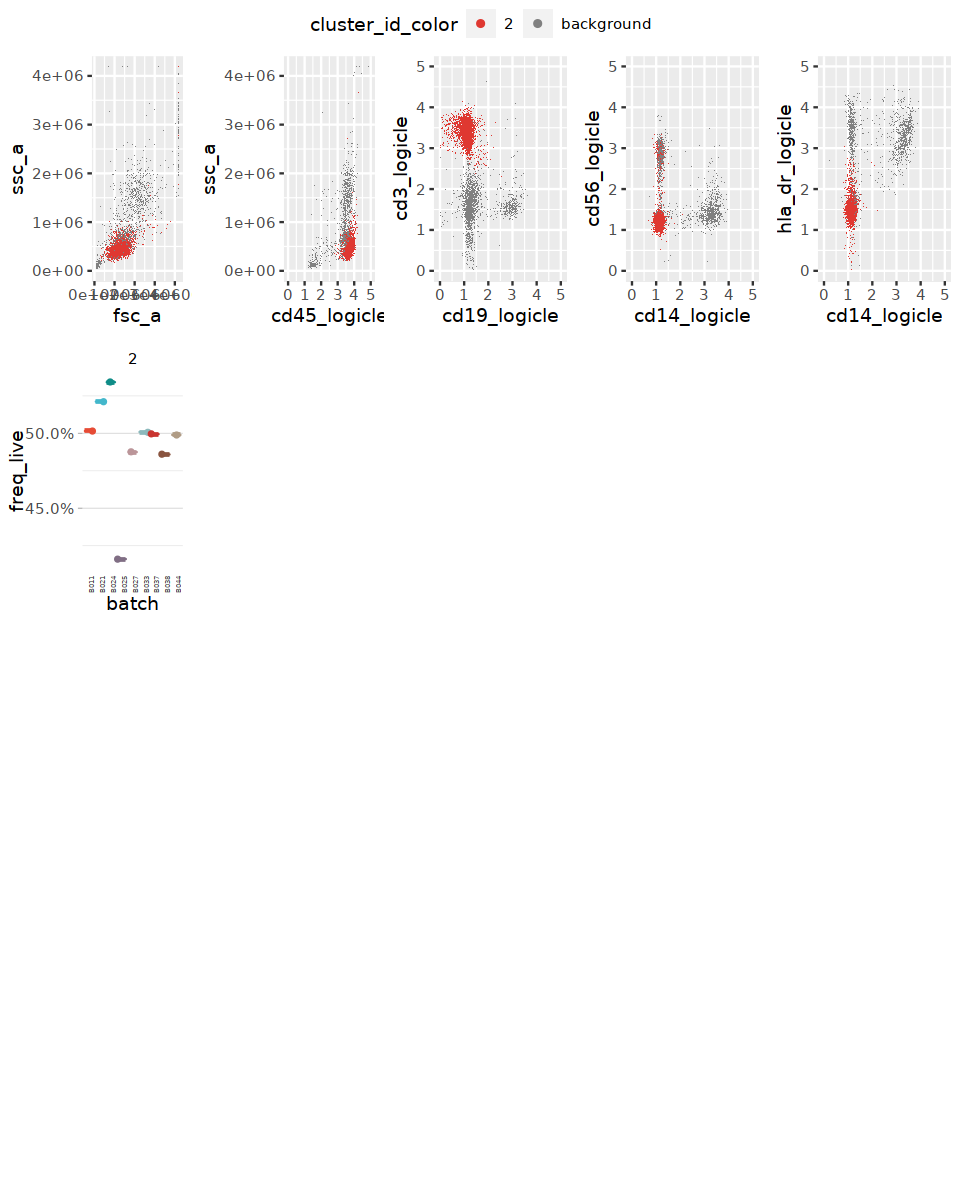

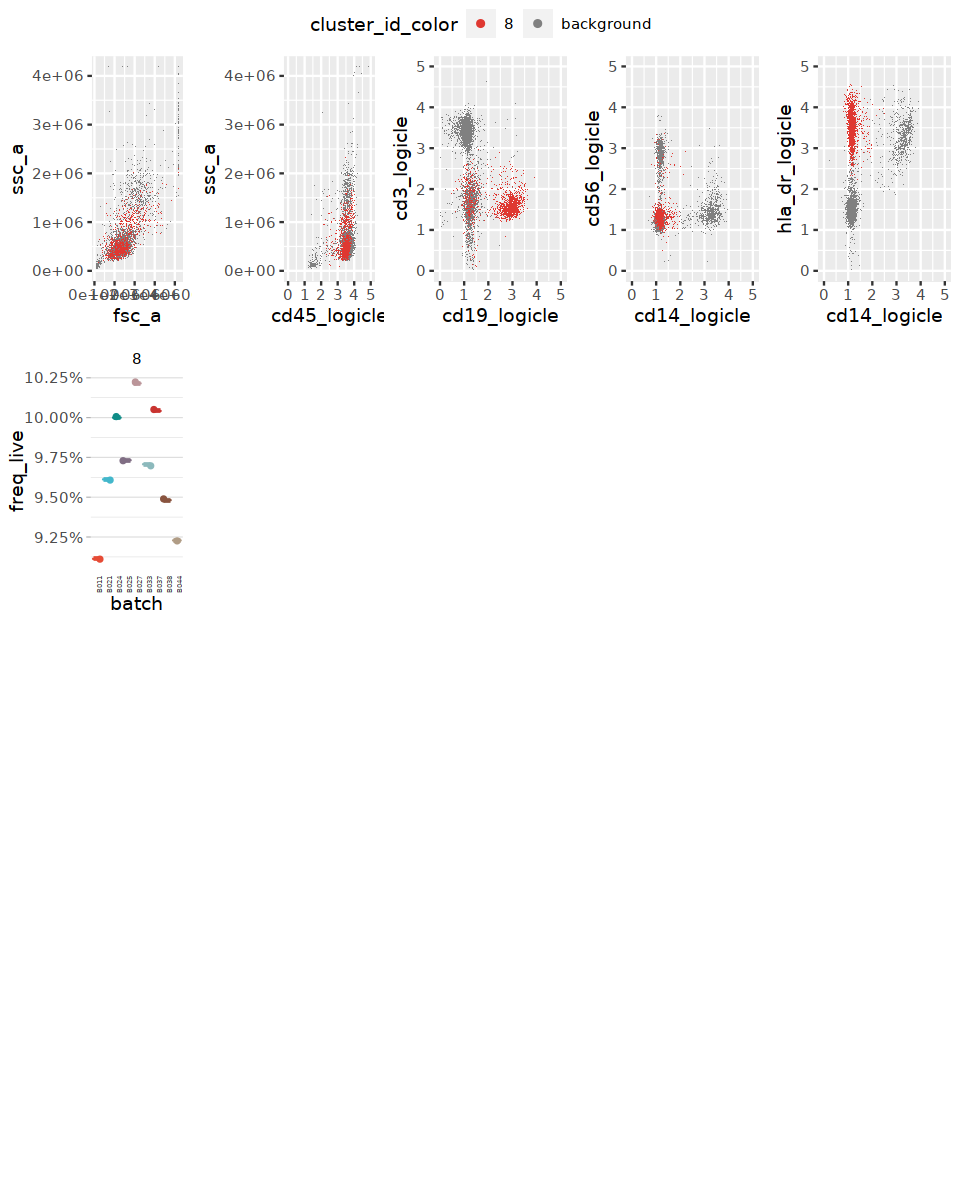

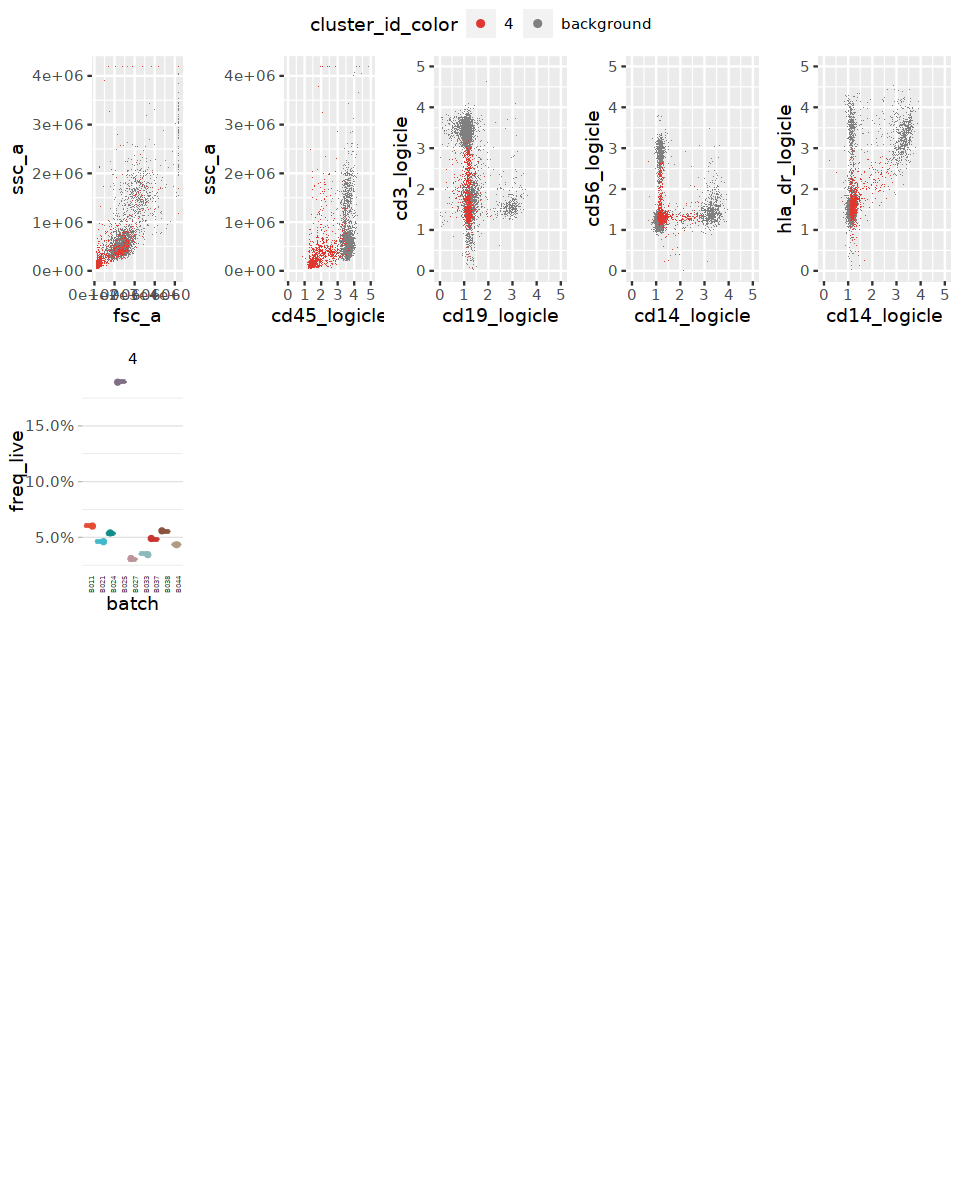

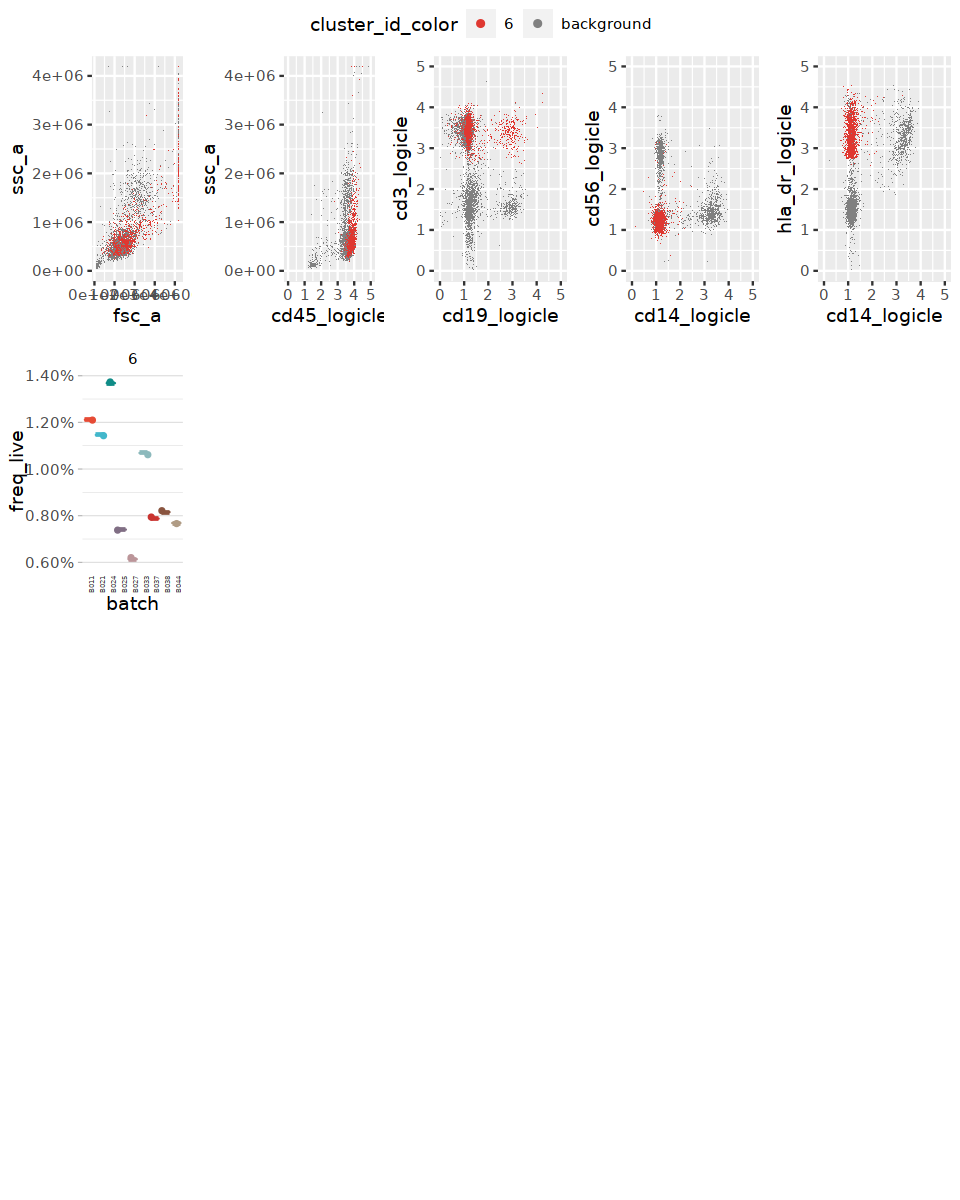

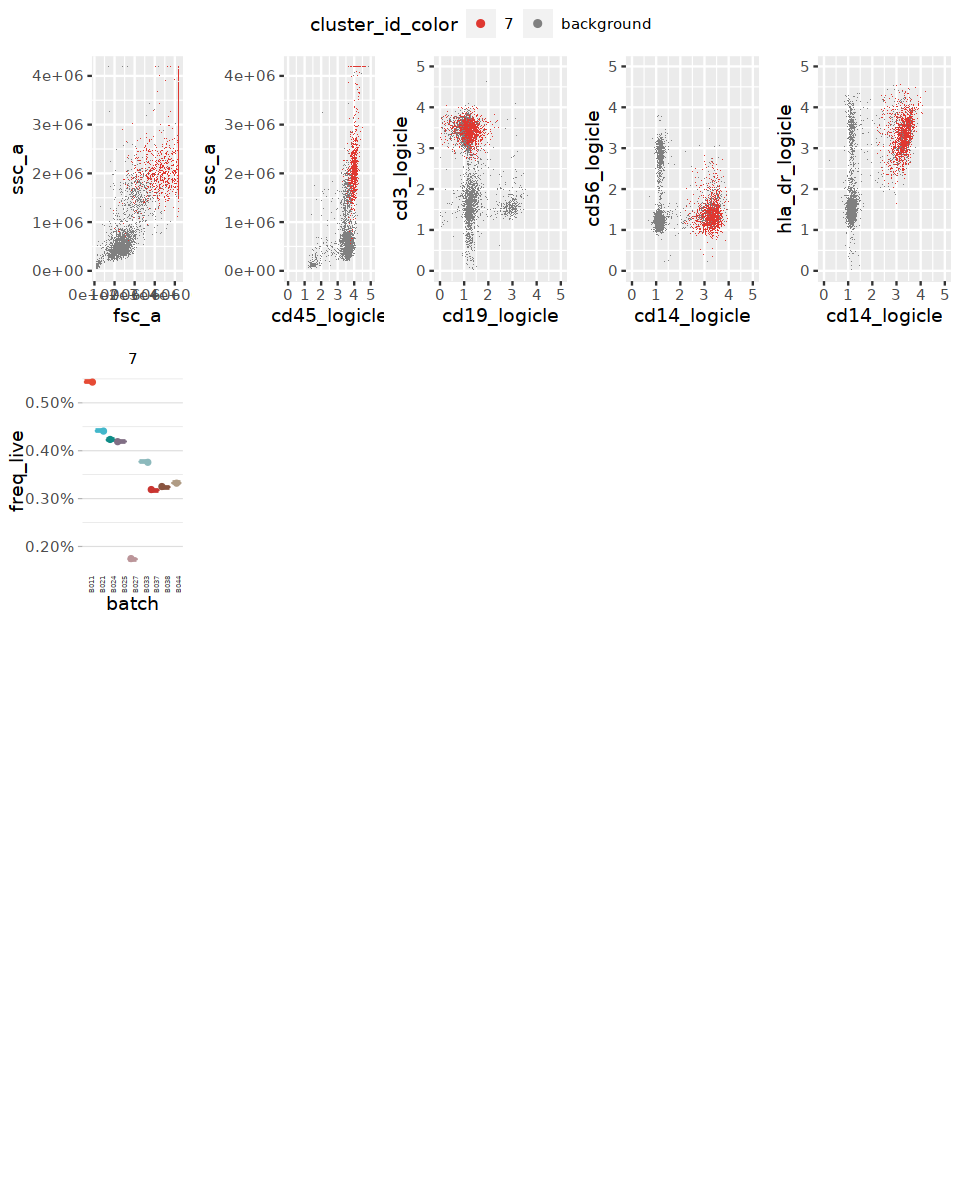

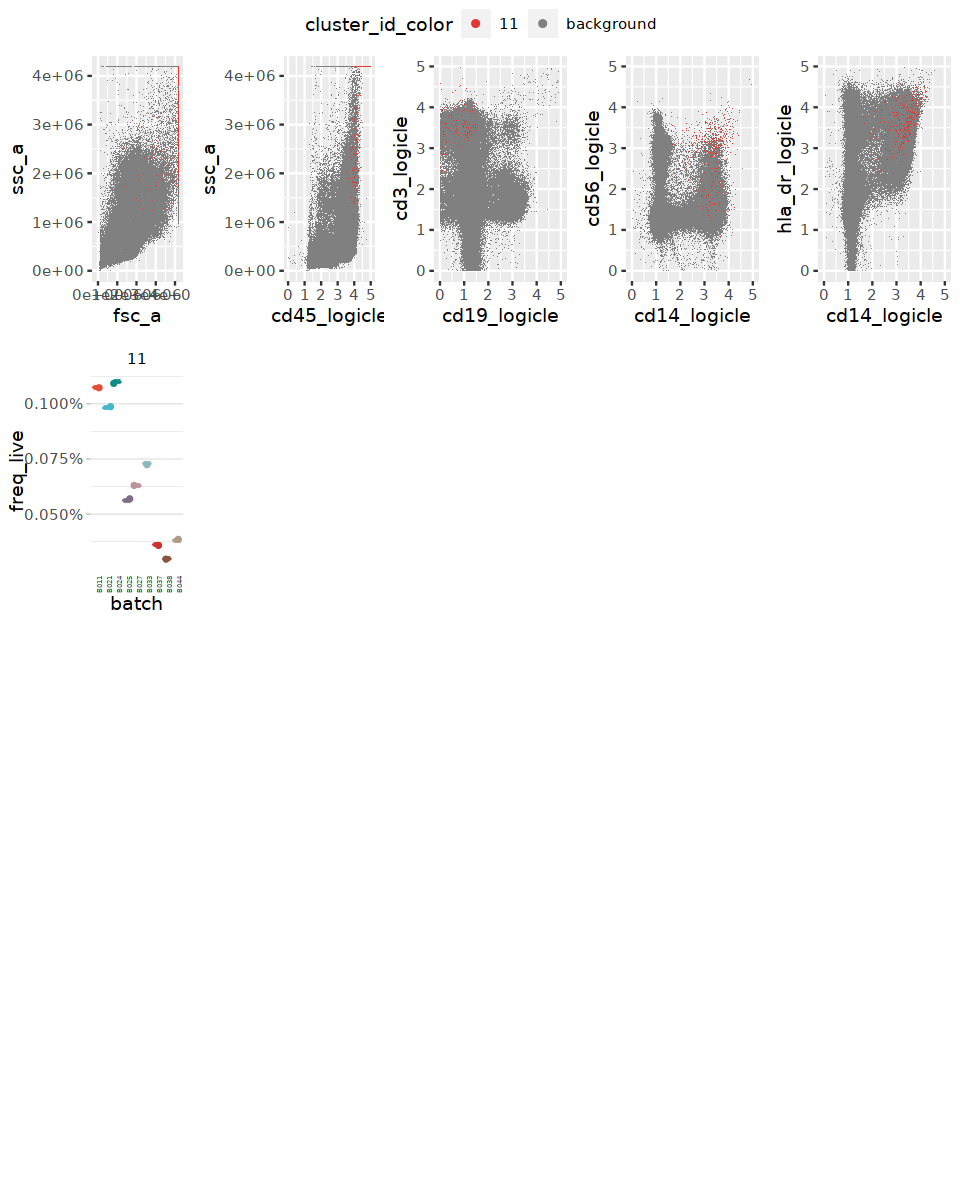

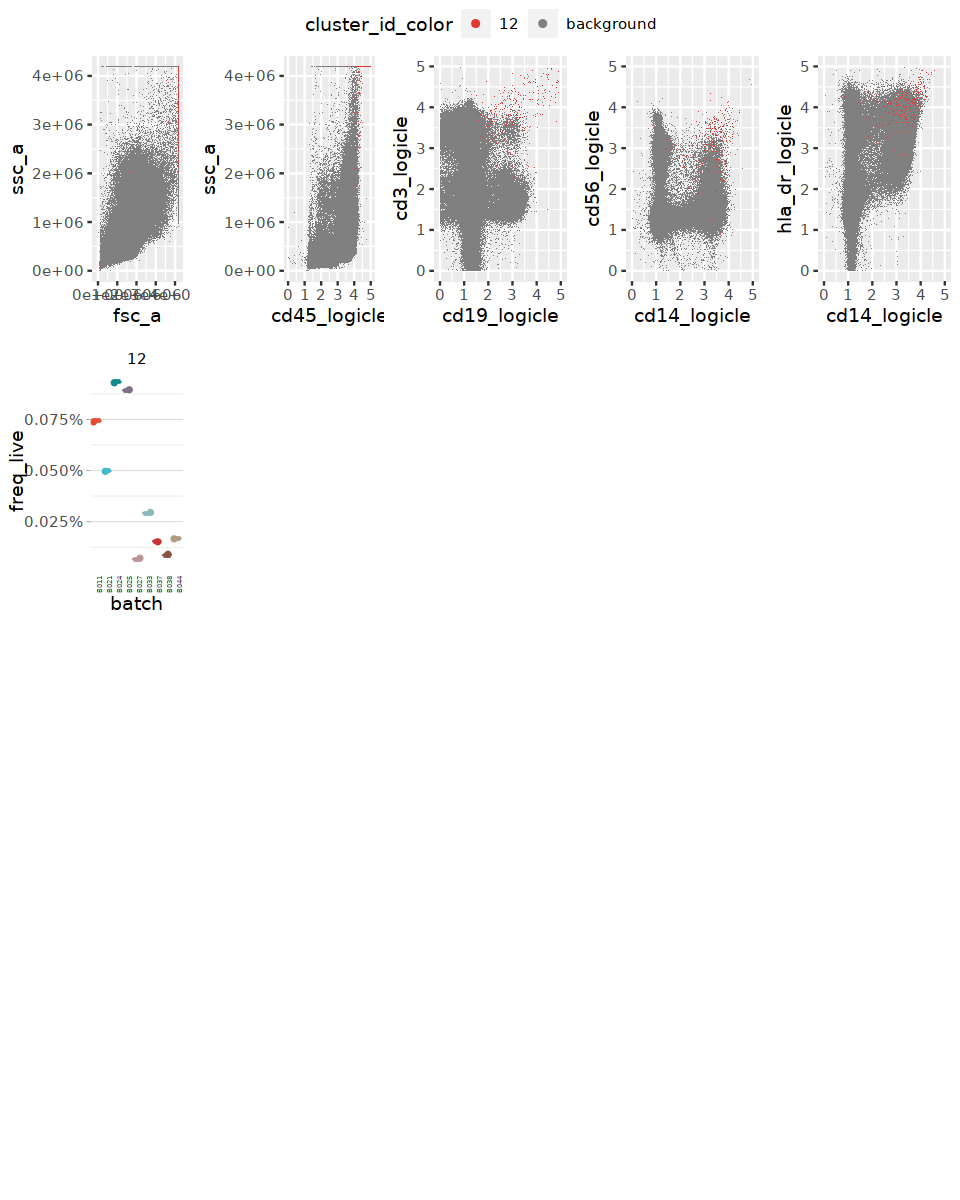

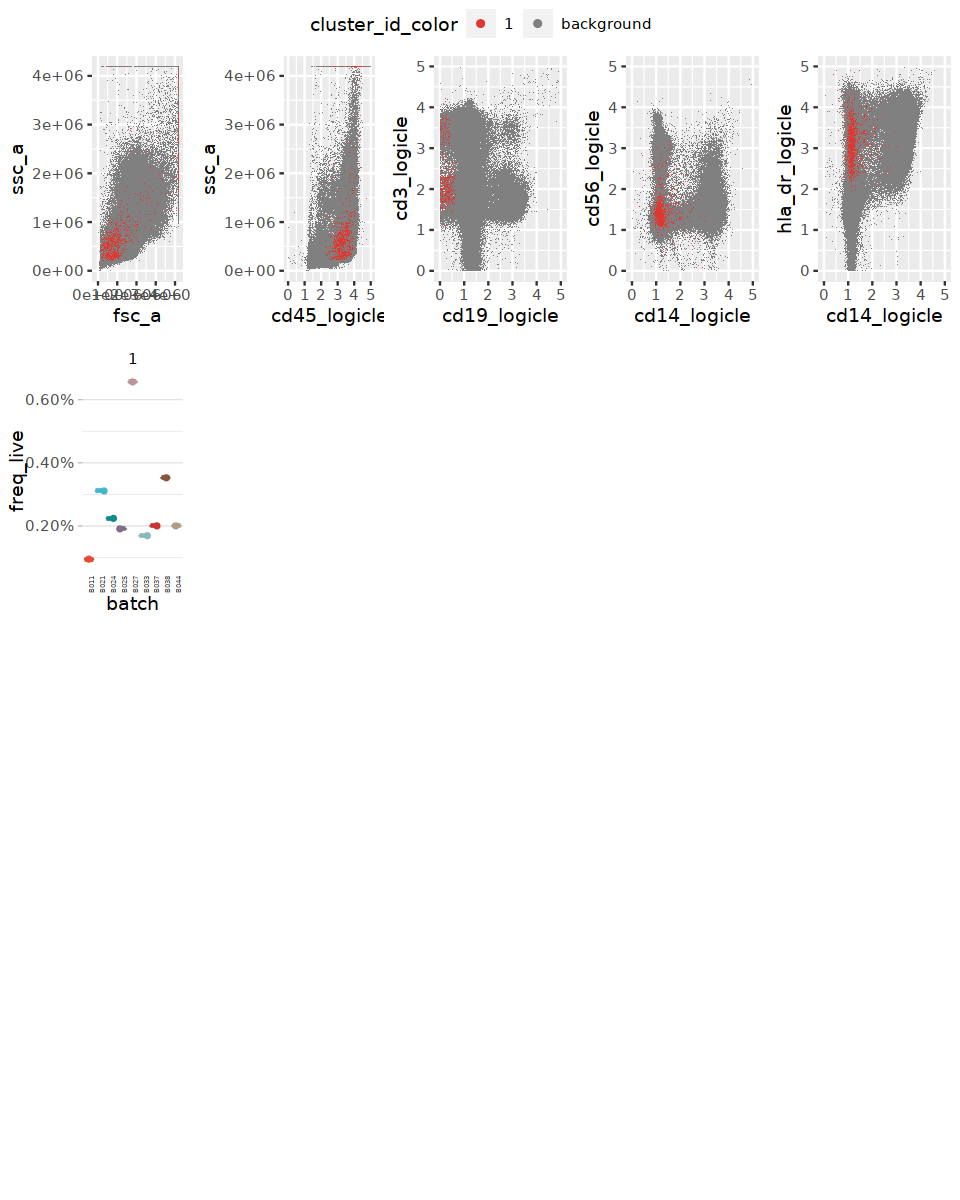

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]


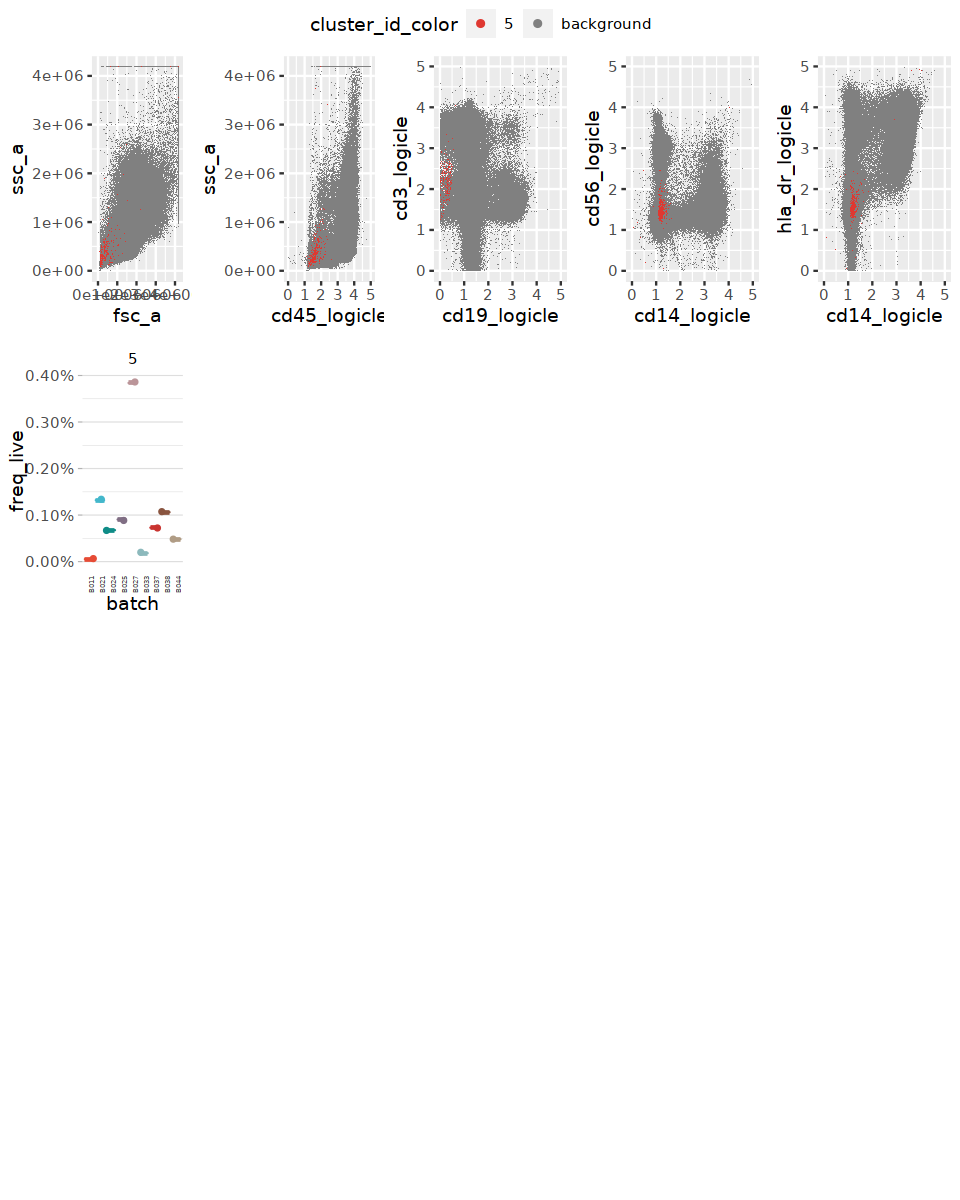

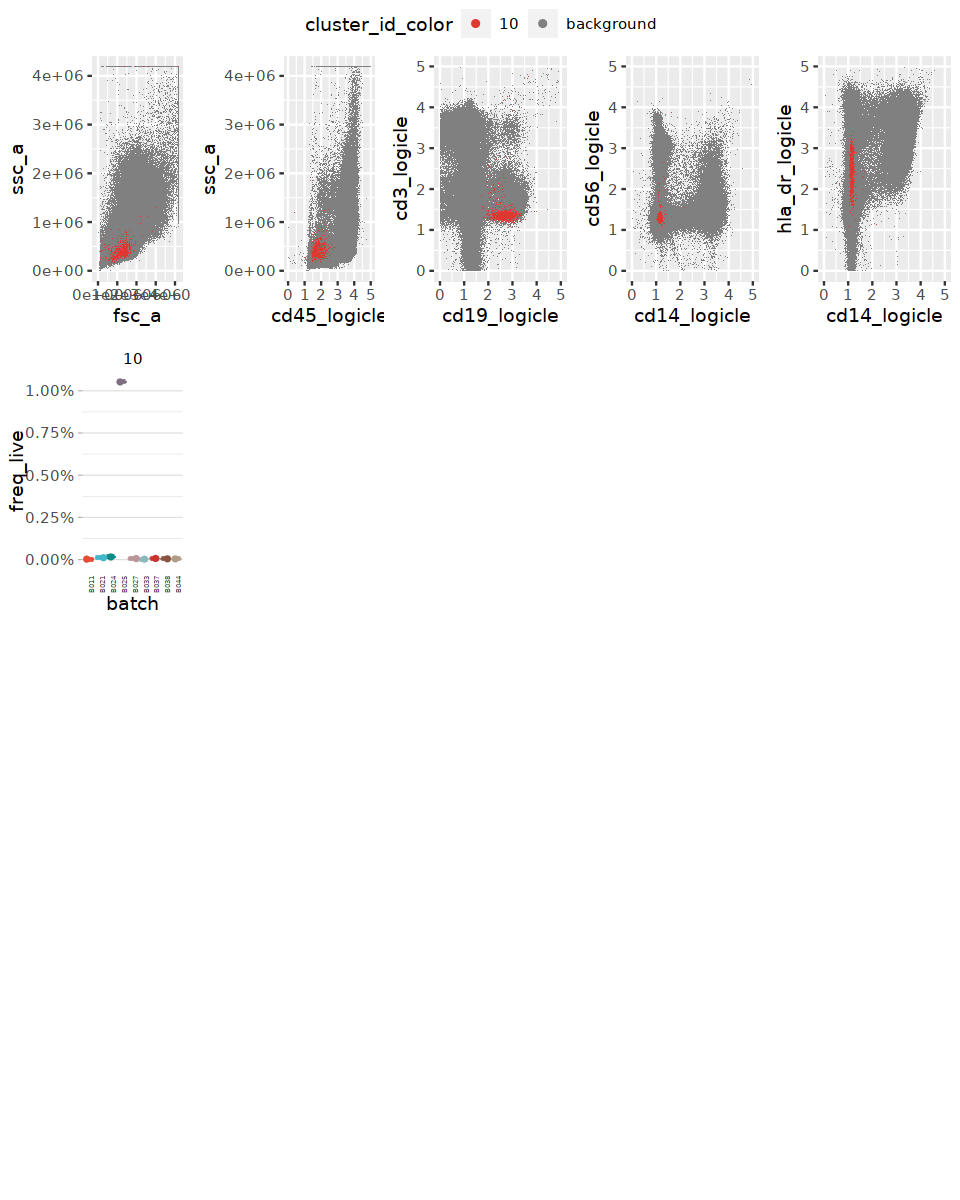

In [29]:
# plot flowjo style expression profiles for each cluster with background to assit cluster identification
plot_pairs_bb <- tibble(
    x_axis=c('fsc_a', 'cd45_logicle', 'cd19_logicle',
             'cd14_logicle', 'cd14_logicle'), 
    y_axis=c('ssc_a', 'ssc_a', 'cd3_logicle',
                 'cd56_logicle', 'hla_dr_logicle'))

# plot the expression profile on each inital cluster for annotation
# function input: 
plot2DMarkers(spec_data=fm_unnorm_bc, plot_pairs=plot_pairs_bb, cluster.col='FlowSOM_meta_bb', 
                       figname=paste0(proj_name, panel_name), subset.cells=10000, ref.cells=30000)

### jump and run until here for new data, annotate after

In [31]:
str(fm_unnorm_bc)

Classes ‘data.table’ and 'data.frame':	3873792 obs. of  66 variables:
 $ Time                  : num  48649 48653 48656 48659 48664 ...
 $ SSC-W                 : num  786963 794626 750110 712202 707542 ...
 $ SSC-H                 : num  1356785 534054 342927 344652 285113 ...
 $ SSC-A                 : num  1779565 707289 428722 409103 336216 ...
 $ FSC-W                 : num  798060 736195 692187 704496 701658 ...
 $ FSC-H                 : num  1186704 1246033 729001 1357614 1123203 ...
 $ FSC-A                 : num  1578436 1528871 841009 1594056 1313508 ...
 $ SSC-B-W               : num  784971 768188 732362 681930 689886 ...
 $ SSC-B-H               : num  1293606 594243 415840 506798 325643 ...
 $ SSC-B-A               : num  1692406 760817 507575 576001 374427 ...
 $ CD14                  : num  100392.2 414 189.4 -80.1 -326.2 ...
 $ CD45                  : num  137645 213669 232648 209674 111579 ...
 $ CD15                  : num  10645 4410 4132 3908 3679 ...
 $ CD56     

In [32]:
library(openCyto)

In [26]:
### important: depending on your own dataset, you will need to edit the annotation numbers in this section ### 
# the major cell type will be annotated by heatmap expression and frequecny generated above

# annotate/merge the clusters and filter out unwanted cluster
annots <- list("T cells" = c(2,6,7),
                "NK cells" = c(3),
                "Myeloid cells" = c(1,9),
                "B cells" = c(8),
                "Other cells" = c(4))
              "Debris" = c(5,10,11,12))
anno_labels <- do.list.switch(annots)
names(anno_labels) <- c("cluster_id", "Population")
setorderv(anno_labels, 'cluster_id')

# add annotations to the dataset
fm_unnorm_bc <- do.add.cols(fm_unnorm_bc, "FlowSOM_meta_bb", anno_labels, "cluster_id")

Step 1/3. Mapping data

Step 2/3. Merging data

Step 3/3. Returning data



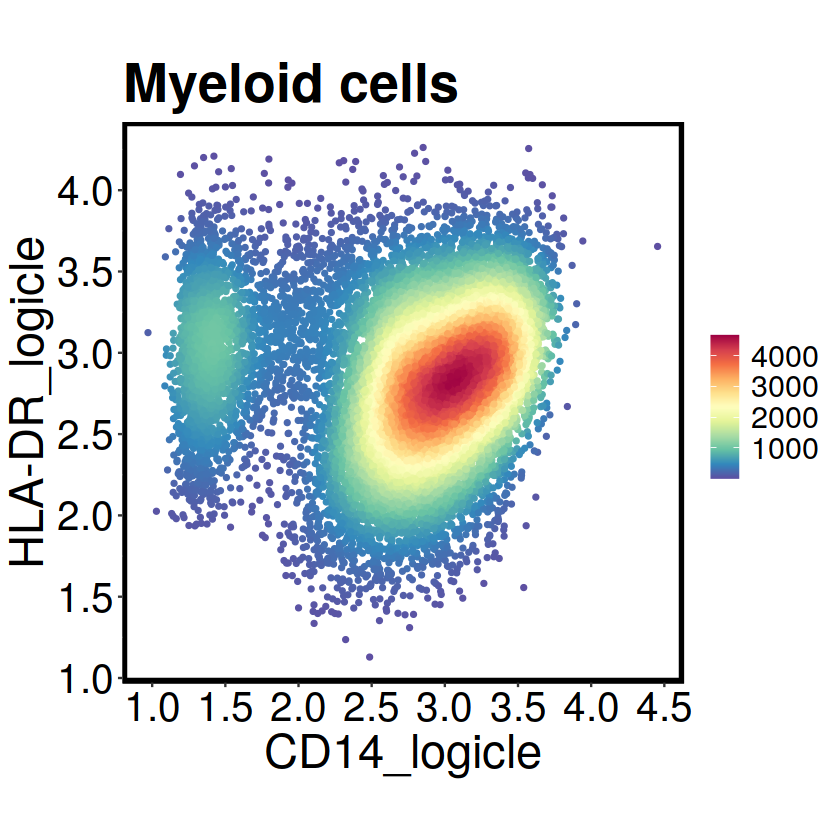

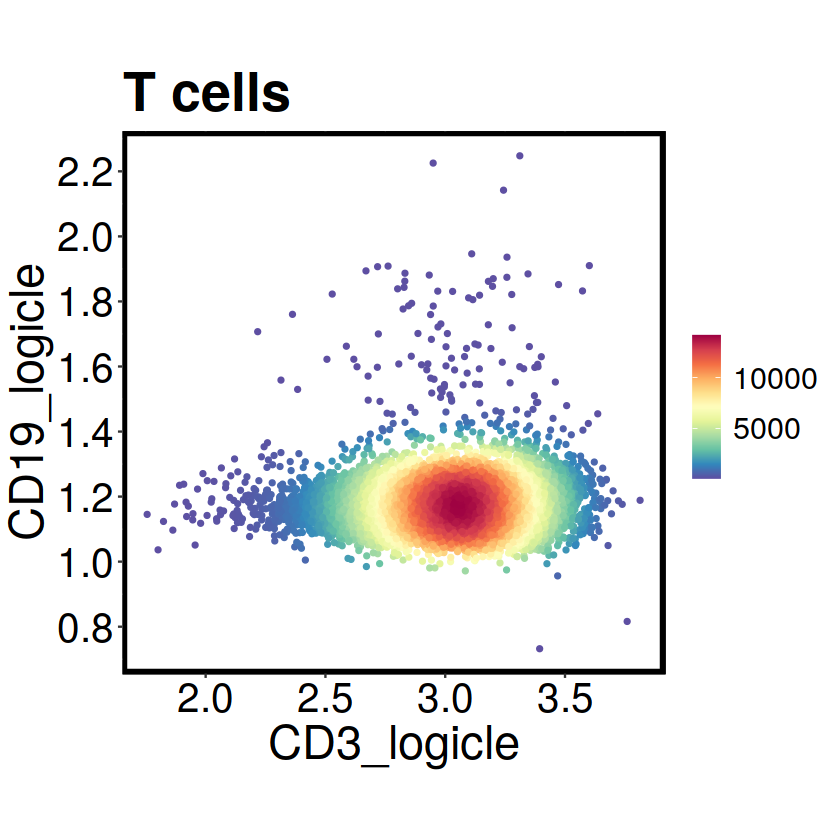

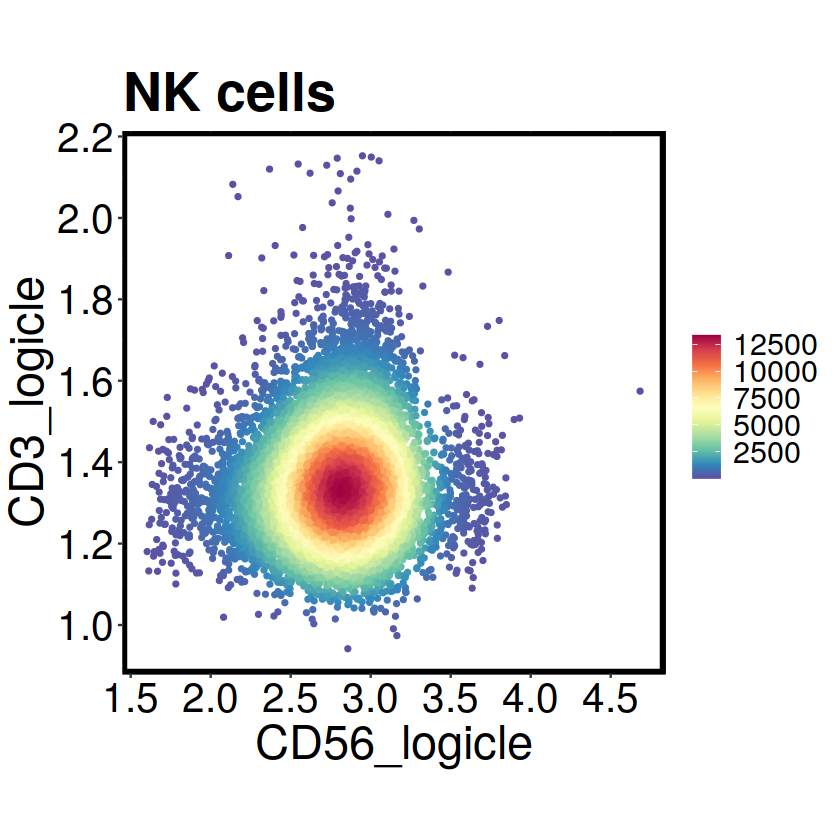

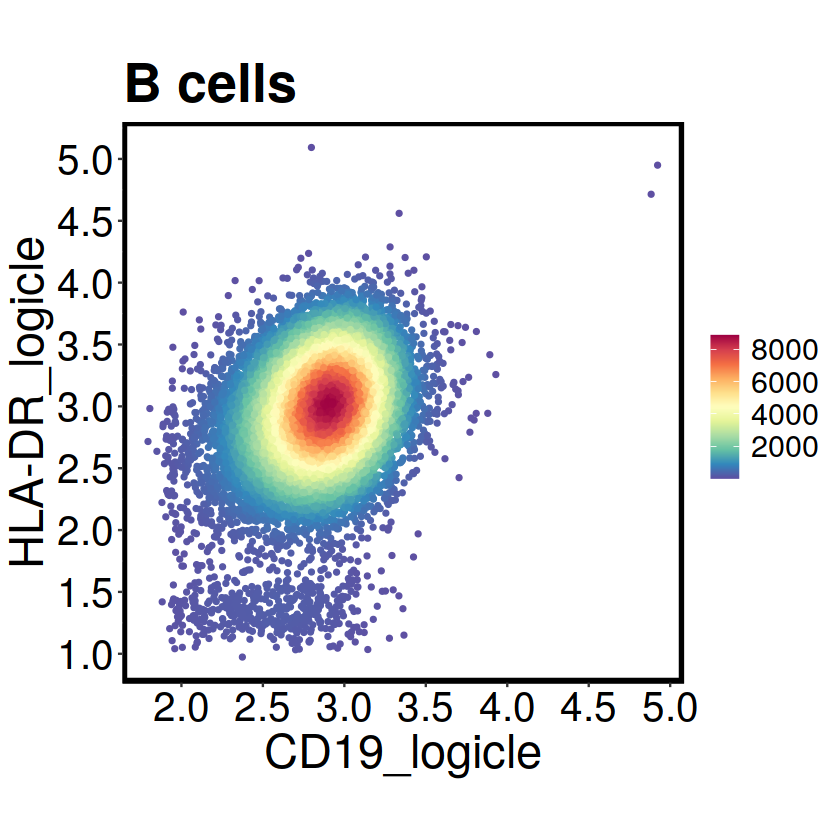

In [27]:
# a quick check on the major marker expression and see if it makes sense
make.colour.plot(do.subsample(fm_unnorm_bc[Population=='Myeloid cells'], 20000), 'CD14_logicle', 'HLA-DR_logicle',
                 save.to.disk=TRUE,
                 title='Myeloid cells',
                 filename = paste0(proj_name, '_bc_myeloid_cells_cd14_HLA-DR_logicle.pdf'),
                path=file.path(fig_path))
make.colour.plot(do.subsample(fm_unnorm_bc[Population=='T cells'], 20000), 'CD3_logicle', 'CD19_logicle',
                 save.to.disk=TRUE,
                 title='T cells',
                 filename = paste0(proj_name, '_bc_t_cells_cd3_cd19.pdf'),
                path=file.path(fig_path))
make.colour.plot(do.subsample(fm_unnorm_bc[Population=='NK cells'], 20000), 'CD56_logicle', 'CD3_logicle',
                 save.to.disk=TRUE,
                 title='NK cells',
                 filename = paste0(proj_name, '_bc_nk_cells_cd56_cd2.pdf'),
                path=file.path(fig_path))
make.colour.plot(do.subsample(fm_unnorm_bc[Population=='B cells'], 20000), 'CD19_logicle', 'HLA-DR_logicle',
                 save.to.disk=TRUE,
                 title='B cells',
                 filename = paste0(proj_name, '_bc_b_cells_cd19_hla_dr.pdf'),
                path=file.path(fig_path))

In [28]:
# plot the marker density per major population
spec_denstity_plot_bc(fm_unnorm_bc, marker.cols = logc.cols, 
                      figname=paste0(proj_name, panel_name,
                               '_unnomalized_bc_fm12'),
                     cell_type.col='Population', color.pal=npg_color)

Warning message in if (is.na(color.pal)) {:
“the condition has length > 1 and only the first element will be used”


In [29]:
# calcualte MFI and plot heatmap per cluster based on backbone clusters
fm_unnorm_bc.mfi <- do.aggregate(dat = fm_unnorm_bc, use.cols = logc.cols, by = 'Population')
# make a heatmap
make.pheatmap(dat = fm_unnorm_bc.mfi, sample.col = 'Population', plot.cols = logc.cols, 
               path=file.path(fig_path),
              normalise=TRUE,
              plot.title='fm12_backbone',
              standard.colours='rev(RdBu)',
              file.name=paste0(proj_name, panel_name,
                               '_bc_bb_markers_flowsom12_merge_seed3_123_exprs_heatmap_anno.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/figuresUP2_unsupPB1_bc_bb_markers_flowsom12_merge_seed3_123_exprs_heatmap_anno.pdf



In [30]:
# calculate and plot umap for batch controls
fm_unnorm_bc.umap <- spectre_umap(fm_unnorm_bc, sub_cells=10000, cols_to_use=logc.cols, n_threads=12)

In [31]:
fm_unnorm_bc.umap %>% head()

Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,FSC-A,SSC-B-W,SSC-B-H,SSC-B-A,⋯,CD85j_logicle,CD19_logicle,CD40_logicle,batch,sample_type,FlowSOM_cluster_bb,FlowSOM_meta_bb,Population,umap_x,umap_y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
183121,685251.1,517453,590975.4,650229.6,692463,750433.2,670138.9,449595,502151.8,⋯,1.337632,1.248142,1.263589,B046,batch controller,97,9,NK cells,1.644946,-10.108104
165761,685816.4,716098,818519.6,689531.1,974197,1119565.1,684947.2,868876,991890.4,⋯,1.002239,1.150751,1.173031,B046,batch controller,78,9,NK cells,1.608387,-7.485724
285755,798062.1,840848,1118414.9,711076.8,921398,1091974.5,781553.4,811837,1057489.9,⋯,2.219164,1.128365,1.328617,B046,batch controller,63,6,Myeloid cells,9.076507,3.984126
215578,706756.4,404705,476713.1,694619.9,1389000,1608045.1,663437.3,506691,560262.9,⋯,1.479385,1.125577,1.182593,B046,batch controller,88,9,NK cells,2.642956,-9.639489
145867,725874.6,677661,819828.2,716704.4,1573580,1879652.8,718138.1,752697,900900.6,⋯,1.148793,1.171781,1.161732,B046,batch controller,88,9,NK cells,3.570477,-7.553804
183665,689712.1,481635,553649.1,681574.2,1313343,1491901.4,677760.9,467965,528613.9,⋯,1.367958,1.230751,1.178061,B046,batch controller,97,9,NK cells,1.857484,-10.297023


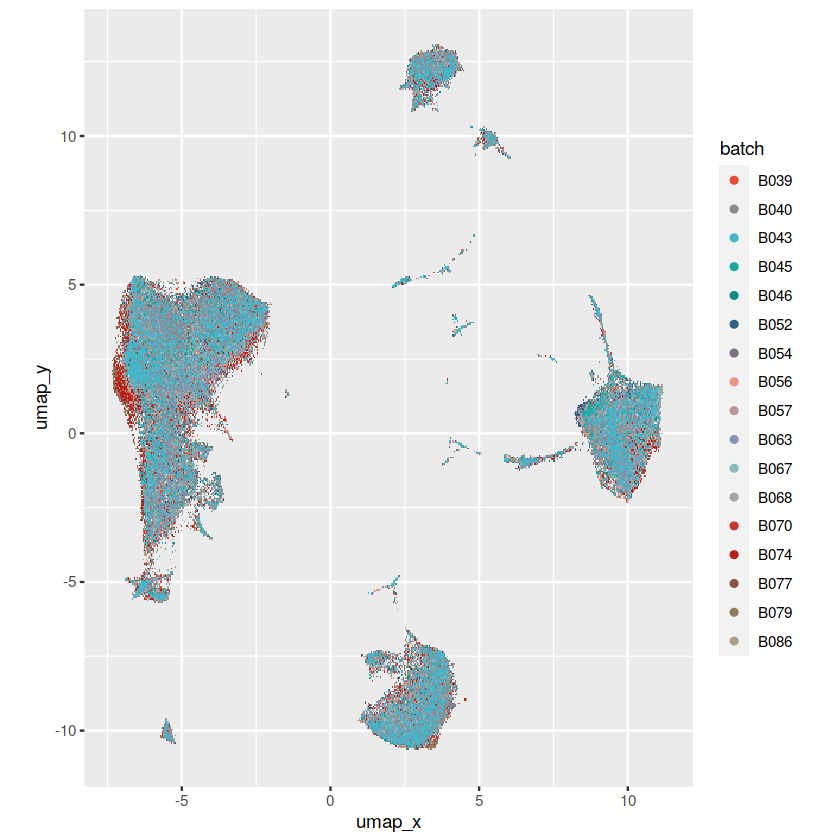

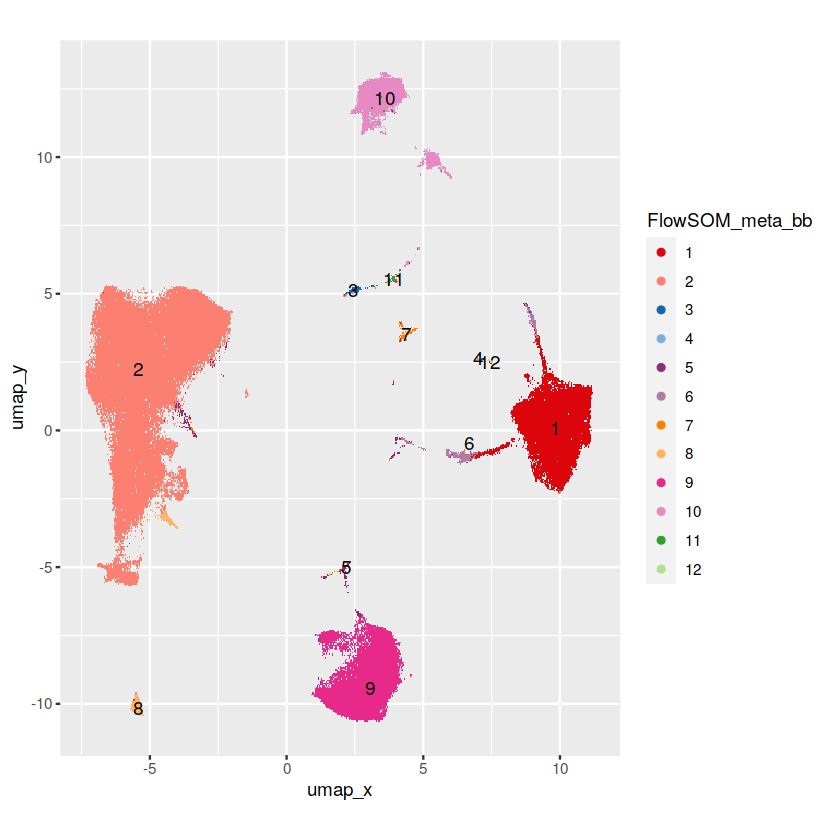

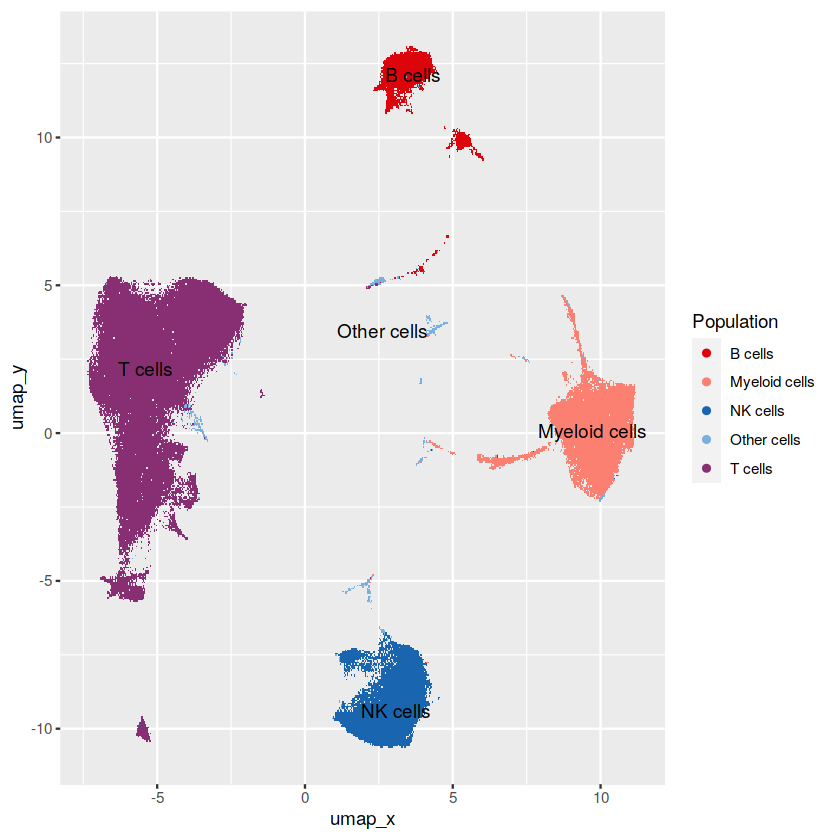

In [32]:
# plot umap results
spec_plot_umap(fm_unnorm_bc.umap, color_by='batch', 
               color_pal=batch_pal, figname=paste0(proj_name, panel_name,
                               '_bc_unormalized_sub100000_batch'))
spec_plot_umap(fm_unnorm_bc.umap, color_by='FlowSOM_meta_bb', 
               color_pal =cluster_colors, label=TRUE,
               figname=paste0(proj_name, panel_name,
                               '_bc_unormalized_fm12_sub100000'))
spec_plot_umap(fm_unnorm_bc.umap, color_by='Population', 
               color_pal =cluster_colors, label=TRUE,
               figname=paste0(proj_name, panel_name,
                               '_bc_unormalized_fm12_sub100000_annotate'))

In [33]:
# map new clincal data to previous flowsom model built on batch controls 
# and return the flowsom result for the new mapping
flow_unnorm_data.mapping <- flowsom_map(flowsom_model=fm_unnorm_bc.md, new_spec_data = flow_unnorm_data, use.cols=bb.logc.cols)

Warning message in FlowSOM::NewData(fsom = flowsom_model, input = dat.ff):
“1056247 cells (2.94%) seem far from their cluster centers.”


In [34]:
flow_unnorm_data %>% head()

Time,SSC-W,SSC-H,SSC-A,FSC-W,FSC-H,FSC-A,SSC-B-W,SSC-B-H,SSC-B-A,⋯,IgG_logicle,CD27_logicle,CD86_logicle,CD10_logicle,CD21_logicle,CD85j_logicle,CD19_logicle,CD40_logicle,batch,sample_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
49165,737392.8,716842,880990.2,709948.8,1050266,1242725.2,734227.8,550551,673716.4,⋯,1.249588,3.202360,1.205967,1.221415,1.192602,1.255037,1.132604,1.253340,B079,sample
49165,779948.6,612628,796363.9,763929.4,1045204,1330770.2,753869.9,518627,651628.8,⋯,1.197507,2.598208,1.152128,1.237544,1.153967,1.267553,1.130297,1.207624,B079,sample
49166,740541.8,687531,848575.7,725820.2,945508,1143781.5,733321.0,555225,678596.9,⋯,1.212394,2.664886,1.413060,1.154948,1.191910,1.136219,1.261298,1.194195,B079,sample
49182,703230.9,497613,583228.1,693905.7,1055029,1220151.1,690275.8,465036,535005.1,⋯,1.212108,2.371461,2.144511,1.269056,1.300212,1.239102,1.300486,1.145555,B079,sample
49182,715305.0,470488,560904.1,692179.5,635767,733441.5,697608.5,318121,369873.2,⋯,1.240620,1.229972,1.126670,1.050237,1.171049,1.181080,1.289725,1.275814,B079,sample
49184,662634.4,591787,653564.0,693670.8,1058881,1224191.2,664110.3,473394,523976.4,⋯,1.221236,3.291642,1.234574,1.132944,1.404699,1.184735,1.242736,1.284011,B079,sample


In [35]:
# map the clinical samples to the flowsom clusters did from the batch controls
flow_unnorm_data <- fm_cluster_match(flow_unnorm_data, flow_unnorm_data.mapping)
# change the names of colnames of the orginal flowsom clustring with backbone clusters
setnames(flow_unnorm_data, c('FlowSOM_cluster', 'FlowSOM_metacluster'),
          c('FlowSOM_cluster_bb', 'FlowSOM_meta_bb'))

In [36]:
# # add population annotations to the whole dataset
flow_unnorm_data <- do.add.cols(flow_unnorm_data, "FlowSOM_meta_bb", anno_labels, "cluster_id")

Step 1/3. Mapping data

Step 2/3. Merging data

Step 3/3. Returning data



In [37]:
# calcualte MFI and plot heatmap per cluster based on backbone clusters
flow_unnorm_data.mfi <- do.aggregate(dat = flow_unnorm_data, use.cols = logc.cols, by = 'Population')
# make a heatmap
make.pheatmap(dat = flow_unnorm_data.mfi, sample.col = 'Population', plot.cols = logc.cols, 
               path=file.path(fig_path),
              normalise=TRUE,
              plot.title='fm12_backbone',
              standard.colours='rev(RdBu)',
              file.name=paste0(proj_name, panel_name,
                               '_bb_flowsom12_seed3_123_exprs_heatmap_anno.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/figuresUP2_unsupPB1_bb_flowsom12_seed3_123_exprs_heatmap_anno.pdf



In [38]:
# save the unnormalized data
 fwrite(flow_unnorm_data, file.path(output_path, paste0(proj_name, panel_name,
                                "_unnormalized_all_cells_fm12_bb_annotate.csv")))

## perfrom batch correction with median offset

In [39]:
# perform batch normalization median alignment for PS1
flow_norm_data <- normalize_median_offset(flow_unnorm_data, marker.cols=logc.cols, 
                                          pop.col='Population')

In [40]:
# check at the batch controls after normaliation
flow_norm_bc <- flow_norm_data[sample_type == 'batch controller']

In [41]:
# calcualte MFI and plot heatmap per cluster based on backbone clusters
fm_unnorm_bc.mfi <- do.aggregate(dat = flow_norm_bc, use.cols = bb.logc.cols, by = 'Population')
# make a heatmap
make.pheatmap(dat = fm_unnorm_bc.mfi, sample.col = 'Population', plot.cols = bb.logc.cols, 
               path=file.path(fig_path),
              normalise=TRUE,
              plot.title='fm12_backbone',
              standard.colours='rev(RdBu)',
              file.name=paste0(proj_name, panel_name,
                               '_bc_bb_markers_flowsom12_merge_seed3_123_exprs_heatmap_anno.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/figuresUP2_unsupPB1_bc_bb_markers_flowsom12_merge_seed3_123_exprs_heatmap_anno.pdf



In [42]:
# plot the marker density per cluster
spec_denstity_plot_bc(flow_norm_bc, marker.cols = align.cols, figname=paste0(proj_name, panel_name,
                               '_nomalized_bc'),
                     cell_type.col='Population', color.pal=npg_color)
### the density plots are set up to allow the user to check how the batch correction is working

Warning message in if (is.na(color.pal)) {:
“the condition has length > 1 and only the first element will be used”


ERROR: Error: Insufficient values in manual scale. 17 needed but only 10 provided.


In [43]:
# calculate and plot umap for batch controls
flow_norm_bc.umap <- spectre_umap(flow_norm_bc, sub_cells=100000, cols_to_use=align.cols, n_threads=12)

# plot umap results
spec_plot_umap(flow_norm_bc.umap, color_by='batch', 
               color_pal=batch_pal, figname=paste0(proj_name, panel_name,
                               '_bc_normalized_batch'))
# spec_plot_umap(flow_norm_bc.umap, color_by='FlowSOM_meta_bb', 
#                color_pal =cluster_colors, label=TRUE,
#                figname='BR1_BR2_PM1_batch_controls_fm6_sub10000')
spec_plot_umap(flow_norm_bc.umap, color_by='Population', 
               color_pal =cluster_colors, label=TRUE,
               figname=paste0(proj_name, panel_name,
                               '_bc_normalized_fm12_annotate'))

In [ ]:
# save the normalized data for future use
fwrite(flow_norm_data, file.path(output_path, paste0(proj_name, panel_name,
                                "_normalized_all_cells_fm12_bb_annotate.csv")))

### Rerun FlowSOM clustering in the target cell population to annotate cell types

In [ ]:
# load the normalized data if previous saved
# flow_norm_data <- fread(file.path(output_path, paste0(proj_name, panel_name,
#                                "_normalized_all_cells_fm12_bb_annotate.csv")))

In [44]:
# define the aligned colnames
align.cols <- paste0(logc.cols, '_aligned')
align.cl.cols <- paste0(cluster.cols, '_logicle_aligned')
align.bb.cols <- paste0(bb_markers, '_logicle_aligned')

In [45]:
flow_norm_data %>% distinct(Population) %>% as_tibble()

Population
<chr>
B cells
Myeloid cells
NK cells
Other cells
T cells


In [46]:
# extract the B cells population and redo clustering
flow_norm_b_cells <- flow_norm_data[Population=='B cells']
# check how many cells were removed
nrow(flow_norm_b_cells)/nrow(flow_norm_data)
# optional remove the orginal data to save memory
# rm(flow_norm_data)

[1] 0.0722426

In [47]:
# load the normalized flowsom clustering data 
flow_norm_t_cells <- fread(file.path(output_path, 
                          paste0(proj_name, panel_name, "_normalized_cells_flowsom_spec.csv"))) %>% 
    select(-c(FlowSOM_cluster_40, FlowSOM_meta_spe)) %>% as.data.table()


ERROR: Error in fread(file.path(output_path, paste0(proj_name, panel_name, "_normalized_cells_flowsom_spec.csv"))): File '/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/UP2_unsupPB1_normalized_cells_flowsom_spec.csv' does not exist or is non-readable. getwd()=='/home/jupyter/UP2/flow'


In [48]:
# Run FlowSOM with only T cells cells using phenotypic marker
fm_norm <- run.flowsom(flow_norm_b_cells, use.cols=align.cl.cols, 
                             #meta.clust.name="FlowSOM_meta10",
                             xdim=15,
                             ydim=15,
                             meta.k= 40,
                             clust.seed=3, meta.seed=123)
fm_norm[, FlowSOM_cluster:=as.factor(FlowSOM_cluster)]
fm_norm[, FlowSOM_metacluster:=as.factor(FlowSOM_metacluster)]
# rename the cluster column name
# the t cells specific k=40 cluteting information is stored under FlowSOM_meta_spe column
setnames(fm_norm, c('FlowSOM_cluster', 'FlowSOM_metacluster'),
          c('FlowSOM_cluster_spe', 'FlowSOM_meta_spe'))

Preparing data

Starting FlowSOM

Building SOM


Mapping data to SOM


Building MST


Binding metacluster labels to starting dataset

Binding cluster labels to starting dataset



In [49]:
fm_norm %>% colnames()

[1] "Time"                          "SSC-W"                        
 [3] "SSC-H"                         "SSC-A"                        
 [5] "FSC-W"                         "FSC-H"                        
 [7] "FSC-A"                         "SSC-B-W"                      
 [9] "SSC-B-H"                       "SSC-B-A"                      
[11] "CD38"                          "CD45"                         
[13] "IgM"                           "CD56"                         
[15] "CD24"                          "CD319"                        
[17] "CD20"                          "CD269 (BCMA)"                 
[19] "IgD"                           "Viability"                    
[21] "CD268 (BR3)"                   "CD71"                         
[23] "CD274 (PD-L1)"                 "CD3"                          
[25] "HLA-DR"                        "IgA"                          
[27] "CD14"                          "IgG"                          
[29] "CD27"                          "CD86"                         
[31] "CD10"                          "CD21"                         
[33] "CD85j"                         "CD19"                         
[35] "CD40"                          "sample_id"                    
[37] "CD38_logicle"                  "CD45_logicle"                 
[39] "IgM_logicle"                   "CD56_logicle"                 
[41] "CD24_logicle"                  "CD319_logicle"                
[43] "CD20_logicle"                  "CD269 (BCMA)_logicle"         
[45] "IgD_logicle"                   "CD268 (BR3)_logicle"          
[47] "CD71_logicle"                  "CD274 (PD-L1)_logicle"        
[49] "CD3_logicle"                   "HLA-DR_logicle"               
[51] "IgA_logicle"                   "CD14_logicle"                 
[53] "IgG_logicle"                   "CD27_logicle"                 
[55] "CD86_logicle"                  "CD10_logicle"                 
[57] "CD21_logicle"                  "CD85j_logicle"                
[59] "CD19_logicle"                  "CD40_logicle"                 
[61] "batch"                         "sample_type"                  
[63] "FlowSOM_cluster_bb"            "FlowSOM_meta_bb"              
[65] "Population"                    "CD38_logicle_aligned"         
[67] "CD45_logicle_aligned"          "IgM_logicle_aligned"          
[69] "CD56_logicle_aligned"          "CD24_logicle_aligned"         
[71] "CD319_logicle_aligned"         "CD20_logicle_aligned"         
[73] "CD269 (BCMA)_logicle_aligned"  "IgD_logicle_aligned"          
[75] "CD268 (BR3)_logicle_aligned"   "CD71_logicle_aligned"         
[77] "CD274 (PD-L1)_logicle_aligned" "CD3_logicle_aligned"          
[79] "HLA-DR_logicle_aligned"        "IgA_logicle_aligned"          
[81] "CD14_logicle_aligned"          "IgG_logicle_aligned"          
[83] "CD27_logicle_aligned"          "CD86_logicle_aligned"         
[85] "CD10_logicle_aligned"          "CD21_logicle_aligned"         
[87] "CD85j_logicle_aligned"         "CD19_logicle_aligned"         
[89] "CD40_logicle_aligned"          "FlowSOM_cluster_spe"          
[91] "FlowSOM_meta_spe"

In [50]:
# calcualte MFI and plot heatmap per cluster based on backbone clusters
fm_norm.mfi <- do.aggregate(dat = fm_norm, use.cols = align.cols, by = 'FlowSOM_meta_spe')
# make a heatmap
make.pheatmap(dat = fm_norm.mfi, sample.col = 'FlowSOM_meta_spe', plot.cols = align.cols, 
               path=file.path(fig_path),
              normalise=TRUE,
              plot.title='spe_flowsom',
              standard.colours='rev(RdBu)',
              file.name=paste0(proj_name, panel_name,
                               '_FlowSOM_meta_spe_seed3_123_exprs_heatmap.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/figuresUP2_unsupPB1_FlowSOM_meta_spe_seed3_123_exprs_heatmap.pdf



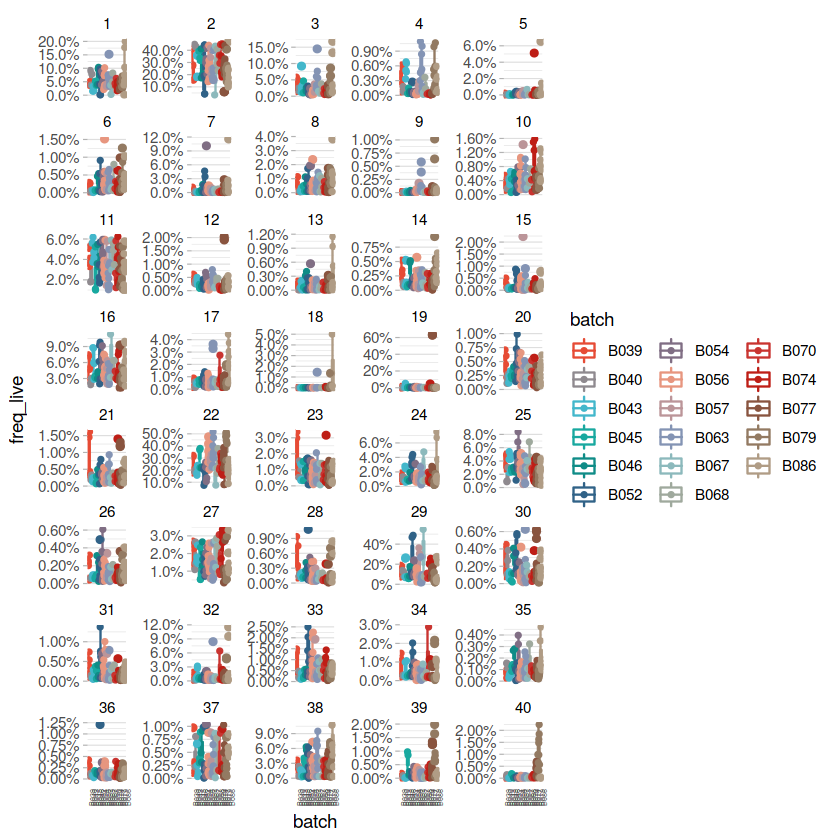

In [51]:
# plot density plot per cluster
Spec_plot_cluster_freq_group(fm_norm, cluster.cols='FlowSOM_meta_spe',group.cols='batch',
                             figname=paste0(proj_name, panel_name,
                               '_nomalized_fm_spec'))
# # plot the marker density per cluster
# spec_denstity_plot_bc(fm_norm, marker.cols = align.cols, figname='BR1_BR2_PS1_nomalized_fm_spec',
#                      cell_type.col='FlowSOM_meta_spe')

In [52]:
# calculate and plot umap for all samples on subsample 100000 cells per samples
fm_norm.umap <- spectre_umap(fm_norm, sub_cells=100000, cols_to_use=align.cols, n_threads=12)


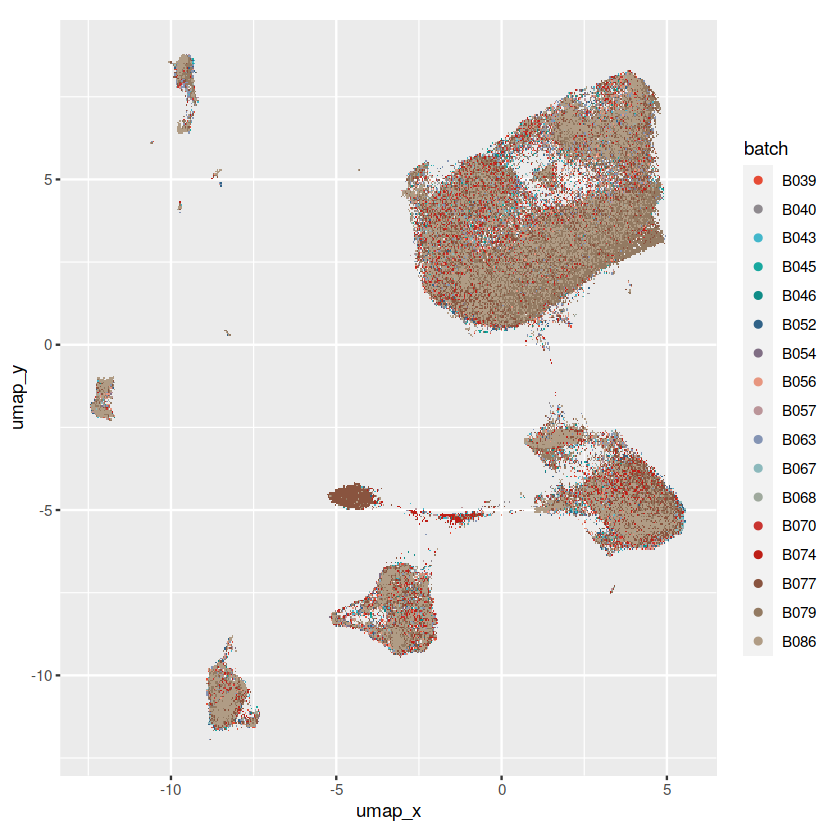

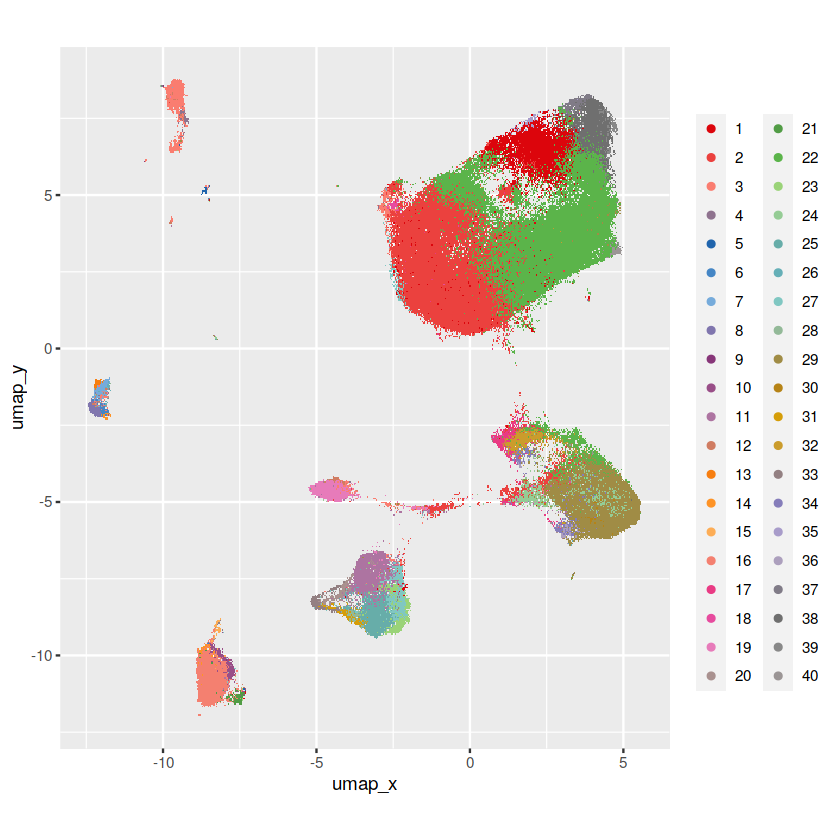

In [53]:
# plot umap results
# create a color palette of number of clusters
cluster_colors <- colorRampPalette(cluster_colors)(60)
spec_plot_umap(fm_norm.umap, color_by='batch', 
               color_pal=batch_pal, figname=paste0(proj_name, panel_name,
                               '_normalized_batch'))
spec_plot_umap(fm_norm.umap, color_by='FlowSOM_meta_spe', 
               color_pal = cluster_colors, label=FALSE,
               figname=paste0(proj_name, panel_name,
                               '_normalized_FlowSOM_spe')) + theme(legend.title = element_blank())
# spec_plot_umap(fm_norm.umap, color_by='FlowSOM_meta_spe', 
#                color_pal = cluster_colors_40, label=TRUE,
#                figname='BR1_BR2_PS1_normalized_FlowSOM_spe_annotate')

In [54]:
fm_norm.umap %>% nrow()
fm_norm %>% nrow()

[1] 225144

[1] 2594058

In [55]:
# save the normalized flowsom clustering data 
fwrite(fm_norm, file.path(output_path, 
                          paste0(proj_name, panel_name, "_normalized_cells_flowsom_spec.csv")))


### set up bivariate expression plot to check each cluster

In [157]:
# load the noramlzied flowsom cluster results.
 fm_norm <- fread(file.path(output_path,paste0(proj_name, panel_name,
                                "_normalized_cells_flowsom_spec.csv")), data.table = TRUE, 
                  nThread = 13)

In [139]:
colnames(fm_norm)

[1] "Time"                          "SSC-W"                        
 [3] "SSC-H"                         "SSC-A"                        
 [5] "FSC-W"                         "FSC-H"                        
 [7] "FSC-A"                         "SSC-B-W"                      
 [9] "SSC-B-H"                       "SSC-B-A"                      
[11] "CD38"                          "CD45"                         
[13] "IgM"                           "CD56"                         
[15] "CD24"                          "CD319"                        
[17] "CD20"                          "CD269 (BCMA)"                 
[19] "IgD"                           "Viability"                    
[21] "CD268 (BR3)"                   "CD71"                         
[23] "CD274 (PD-L1)"                 "CD3"                          
[25] "HLA-DR"                        "IgA"                          
[27] "CD14"                          "IgG"                          
[29] "CD27"                          "CD86"                         
[31] "CD10"                          "CD21"                         
[33] "CD85j"                         "CD19"                         
[35] "CD40"                          "sample_id"                    
[37] "CD38_logicle"                  "CD45_logicle"                 
[39] "IgM_logicle"                   "CD56_logicle"                 
[41] "CD24_logicle"                  "CD319_logicle"                
[43] "CD20_logicle"                  "CD269 (BCMA)_logicle"         
[45] "IgD_logicle"                   "CD268 (BR3)_logicle"          
[47] "CD71_logicle"                  "CD274 (PD-L1)_logicle"        
[49] "CD3_logicle"                   "HLA-DR_logicle"               
[51] "IgA_logicle"                   "CD14_logicle"                 
[53] "IgG_logicle"                   "CD27_logicle"                 
[55] "CD86_logicle"                  "CD10_logicle"                 
[57] "CD21_logicle"                  "CD85j_logicle"                
[59] "CD19_logicle"                  "CD40_logicle"                 
[61] "batch"                         "sample_type"                  
[63] "FlowSOM_cluster_bb"            "FlowSOM_meta_bb"              
[65] "Population"                    "CD38_logicle_aligned"         
[67] "CD45_logicle_aligned"          "IgM_logicle_aligned"          
[69] "CD56_logicle_aligned"          "CD24_logicle_aligned"         
[71] "CD319_logicle_aligned"         "CD20_logicle_aligned"         
[73] "CD269 (BCMA)_logicle_aligned"  "IgD_logicle_aligned"          
[75] "CD268 (BR3)_logicle_aligned"   "CD71_logicle_aligned"         
[77] "CD274 (PD-L1)_logicle_aligned" "CD3_logicle_aligned"          
[79] "HLA-DR_logicle_aligned"        "IgA_logicle_aligned"          
[81] "CD14_logicle_aligned"          "IgG_logicle_aligned"          
[83] "CD27_logicle_aligned"          "CD86_logicle_aligned"         
[85] "CD10_logicle_aligned"          "CD21_logicle_aligned"         
[87] "CD85j_logicle_aligned"         "CD19_logicle_aligned"         
[89] "CD40_logicle_aligned"          "FlowSOM_cluster_spe"          
[91] "FlowSOM_meta_spe"

In [140]:
# load the plotting pairs axis
plot_pairs <- readxl::read_excel(file.path(panel_path, 'Clustering_Bivariate_Plots_axis.xlsx'), 
                                 sheet='PB1') %>% 
    mutate(x_axis=if_else(x_axis %in% c('fsc_a', 'ssc_a'), x_axis, paste0(x_axis, '_logicle_aligned')), 
           y_axis=if_else(y_axis %in% c('fsc_a', 'ssc_a'), y_axis, paste0(y_axis, '_logicle_aligned')))
# check all the column names match
all(plot_pairs$x_axis %in% janitor::make_clean_names(colnames(fm_norm)))
all(plot_pairs$y_axis %in% janitor::make_clean_names(colnames(fm_norm)))

[1] TRUE

[1] TRUE

In [141]:
fm_norm$FlowSOM_meta_spe <- as.character(fm_norm$FlowSOM_meta_spe)
# plot expression profiles 
# function input: 
marker_plot_2d_cluster(spec_data=fm_norm, plot_pairs=plot_pairs, cluster.col='FlowSOM_meta_spe', 
                       figname=paste0(proj_name, panel_name))

Warning message:
“Removed 4 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 9 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 1 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 5 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 21 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 21 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 1 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 10 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 4 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 1 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 6 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 5 rows containing missing values (geom_scattermore).”
Warning message:
“Removed 2 rows cont

### Annotate clusters (manual review required!)

In [158]:
# output the exsisting labels for manunal annotation
fm_norm %>% distinct(FlowSOM_meta_spe) %>% as_tibble() %>% 
    arrange(FlowSOM_meta_spe) %>% 
    write_csv(file.path(output_path, paste0(proj_name, panel_name,
                               '_cell_type_specific_clusters.csv')))


In [159]:
# for survey panel this will be different cluster with the major cell types
fm_norm %>% distinct(FlowSOM_meta_spe) %>% as_tibble() %>% 
    arrange(FlowSOM_meta_spe) %>% distinct() %>% pull(FlowSOM_meta_spe)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40

In [160]:
# load the annoate clusters
# !!! this csv file need to be provided from the user
# it contain two columns: "FlowSOM_meta_spe" (cluster_ids above) 
# and "FlowSOM_meta_spe_anno" (cell type annotation for the clusters)
fm_spe_anno_labels <- read_csv("/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/UP2_unsupPB1_cell_type_specific_clusters_anno.csv", 
                         col_types = cols()) 
# check the cluster labels are the same
all(fm_spe_anno_labels$FlowSOM_meta_spe %in% pull(distinct(fm_norm, FlowSOM_meta_spe)))

New names:
* `` -> ...3

Warning message:
“One or more parsing issues, see `problems()` for details”


[1] TRUE

In [161]:
fm_spe_anno_labels <- fm_spe_anno_labels %>% mutate(FlowSOM_meta_spe_anno = paste0(FlowSOM_meta_spe,"_",FlowSOM_meta_spe_anno))

In [162]:
# add annotations to the dataset and names are in FlowSOM_meta_spe column
fm_norm <- do.add.cols(fm_norm, "FlowSOM_meta_spe", fm_spe_anno_labels, "FlowSOM_meta_spe")

Step 1/3. Mapping data

Step 2/3. Merging data

Step 3/3. Returning data



In [163]:
# calcualte MFI and plot heatmap per annotated populations
fm_norm.mfi <- do.aggregate(dat = fm_norm, use.cols = align.cols, by = 'FlowSOM_meta_spe_anno')


In [164]:
table(is.na(fm_norm$FlowSOM_meta_spe_anno))


  FALSE 
2594058 

In [165]:
# make a heatmap
make.pheatmap(dat = fm_norm.mfi, sample.col = 'FlowSOM_meta_spe_anno', plot.cols = align.cols, 
               path=file.path(fig_path),
              normalise=TRUE,
              plot.title='spe_flowsom',
              standard.colours='rev(RdBu)',
              file.name=paste0(proj_name, panel_name,
                               '_FlowSOM_meta_spe_seed3_123_exprs_heatmap_population.pdf'))

A pheatmap has been saved to your working directory/home/jupyter/UP2/flow/PB1-unsupervised-clustering/output/figuresUP2_unsupPB1_FlowSOM_meta_spe_seed3_123_exprs_heatmap_population.pdf



In [166]:
# calculate and plot umap for all samples on subsample 100000 cells per samples
fm_norm.umap <- spectre_umap(fm_norm, sub_cells=100000, cols_to_use=align.cols, n_threads=12)


New names:
* ...3 -> ...93



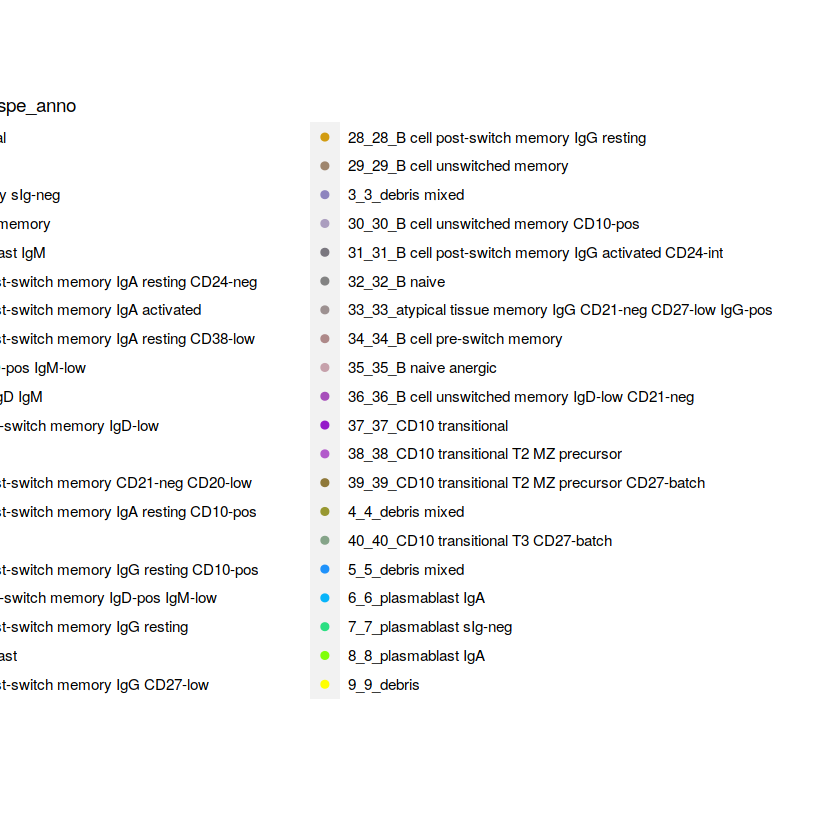

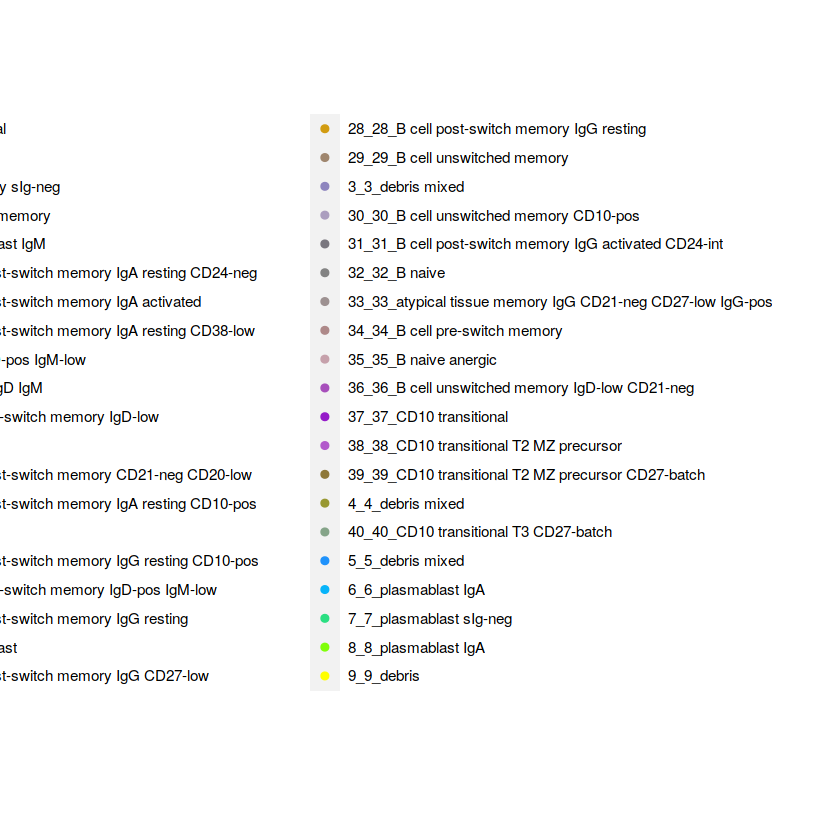

In [178]:

cluster_colors_40 <- colorRampPalette(cluster_colors)(40)
# plot umap
spec_plot_umap(fm_norm.umap, color_by='FlowSOM_meta_spe_anno', 
                label=FALSE, color_pal = cluster_colors_40,
               figname=paste0(proj_name, panel_name,
                               '_normalized_FlowSOM_spe'), width=20,height=20)
spec_plot_umap(fm_norm.umap, color_by='FlowSOM_meta_spe_anno', 
                label=TRUE, color_pal = cluster_colors_40, 
               figname=paste0(proj_name, panel_name,
                               '_normalized_FlowSOM_spe_label'), width=20,height=20)

### Generate frequency and MFI tables

In [168]:
# calcualte frequency of annotated cell type and save
freq_norm <- Spec_cluster_freq(fm_norm, live_counts=NULL, cluster.cols='FlowSOM_meta_spe_anno')
freq_norm %>% head()
freq_norm %>% write_csv(file.path(output_path, paste0(proj_name, panel_name,
                               '_normalized_all_samples_frequency.csv')))

sample_id,FlowSOM_meta_spe_anno,N,freq_live,batch,sample_type,Population,FlowSOM_meta_spe,...3
<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<fct>,<lgl>
PB00352-01,1_1_B transitional,537,0.04683003,B039,sample,B cells,1,NA
PB00352-01,22_22_B naive,2189,0.19089561,B039,sample,B cells,1,NA
PB00352-01,23_23_B cell post-switch memory IgG resting CD10-pos,387,0.03374902,B039,sample,B cells,1,NA
PB00352-01,25_25_B cell post-switch memory IgG resting,558,0.04866138,B039,sample,B cells,1,NA
PB00352-01,29_29_B cell unswitched memory,2069,0.18043080,B039,sample,B cells,1,NA
PB00352-01,2_2_B naive,1780,0.15522805,B039,sample,B cells,1,NA


In [169]:
# calcualte MFI and save
fm_norm.mfi <- do.aggregate(dat = fm_norm, use.cols = align.cols, 
                            by = c('sample_id', 'FlowSOM_meta_spe_anno'))

fm_norm.mfi %>% write_csv(file.path(output_path, paste0(proj_name, panel_name,
                               '_normalized_all_samples_MFI.csv')))

In [170]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/lib/spectra/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dtplyr_1.1.0         forcats_0.5.1        stringr_1.4.0       
 [4] purrr_0.3.4          readr_2.0.2          tibble_3.1.5        
 [7] tidyverse_1.3.1      FlowSOM_2.0.0        igraph_1.2.6        
[10] flowViz_1.56.0       Biobase_2.52.0       BiocGenerics_0.38.0 
[13] flowCore_2.4.0       class_7.3-19         caret_6.0-90        
[16] lattice_0.20-